## **Problem Statement**
- A bank had collected data about historical loan default along with respective information for each member. 
- You need to build a model that will help this bank by predicting the probability that a member will default.


### 1. import all the libraries

In [1]:
#for importing the datasets
import os
#for exploratory Analysis
import pandas as pd
import numpy as np
#for visulaisation
import matplotlib.pyplot as plt
import seaborn as sns
#for preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from collections import OrderedDict
import scipy.stats as sci

#for traintest split
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold,RandomizedSearchCV

#Logistic Regression model
from sklearn.linear_model import LogisticRegression

#visualise the logistic regression output summary
import statsmodels.api as sm

#KNN
from sklearn.neighbors import KNeighborsClassifier

#for modelevaluation: metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,classification_report,auc,precision_recall_curve,accuracy_score,f1_score,fbeta_score, precision_score, recall_score

#supress warnings
import warnings
warnings.filterwarnings("ignore")

from collections import Counter

#feature selection
from sklearn.feature_selection import chi2,RFE,RFECV,f_classif,SelectKBest

#Decission Tree
from sklearn.tree import DecisionTreeClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

#SVM
from sklearn.svm import SVC

#Deal with the minority class
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

#Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
train_df=pd.read_csv('train_data_1.csv')
test_df=pd.read_csv('train_data_2.csv')

In [3]:
def data_checks(df):
    """ Does basic checks on the input dataframe
    
    Args:
        (df): Dataframe 
       
    """
    print('=============INFO====================')
    print(df.info())
    print('\n=============SHAPE====================')
    print(df.shape)

In [4]:
def find_missing_values(df):    
#findout percentage of missing values in the categorical data
    missing_cols_list=[]
    for each in df.columns:
        missing_values=(df[each].isnull().sum()/df.shape[0])*100
        if(missing_values>0):
            missing_cols_list.append((each,(str(missing_values)+'%')))
            
    temp_dict = dict((x,y) for x, y in enumerate(missing_cols_list))
    missing_value_df=pd.DataFrame.from_dict(temp_dict)
    return missing_cols_list,missing_value_df

In [5]:
def treat_missing_values(df,cols_list_with_missing_values):
    for index, tup in enumerate(cols_list_with_missing_values):
        if(df[tup[0]].dtype=='O'):
            df[tup[0]]=df[tup[0]].fillna(df[tup[0]].mode()[0])
        else:
            df[tup[0]]=df[tup[0]].fillna(df[tup[0]].median())

In [6]:
def extract_numeric_value(df,col_list):
    for each in cols_to_numeric_list:
        df[each]= df[each].str.extract('(\d*\.?\d+)',expand=True)
        df[each]=pd.to_numeric(df[each])

In [7]:
def select_cat_features_chi2(x,y):
    f_score=chi2(x,y)   #returns f score and p value 
    chi2_summary_dict={
        'features':list(x.columns),
        'chi2':f_score[0],
        'p-value':f_score[1] 
                      }
    chi2_summary_df=pd.DataFrame.from_dict(data=chi2_summary_dict)
    selected_cols_df=chi2_summary_df[chi2_summary_df['p-value']<0.05]
    selected_features_list=list(selected_cols_df['features'])
    return chi2_summary_df,selected_features_list

In [8]:
def select_features_rfe(X_train, y_train):
    log_reg = LogisticRegression()
    rfe_model = RFECV(log_reg,cv=2,scoring='accuracy') 
    rfe_values=rfe_model.fit(X_train,y_train) 
    rfe_output_dict={
                    'Features':list(X_train.columns),
                    'support':rfe_values.support_,
                    'Ranking':rfe_values.ranking_ 
                    }
    rfe_output_df=pd.DataFrame.from_dict(rfe_output_dict)
    rfe_output_df.sort_values('Ranking',ascending=True,inplace=True)
    rfe_output_df.reset_index(inplace=True)
    feature_list= rfe_output_df[rfe_output_df['Ranking']==1]['Features']
    return rfe_output_df,feature_list

In [9]:
def fn_summary(df):
    summary=[]
    for col in df.columns:
        
        if(df[col].dtypes!='object'):
            
            result_dict=OrderedDict({
            'Feature_Name':col,
            'Count':df[col].count(),
            'Q1':df[col].quantile(0.25),
            'Q2':df[col].quantile(0.50),
            'Q3':df[col].quantile(0.75),
            'mean':df[col].mean(),
            'min':df[col].min(),
            'max':df[col].max(),
            'variance':np.round(df[col].var(),2),
            'std_dev':df[col].std(),
            'skewness': df[col].skew(),
            'kurtosis': df[col].kurt()})
            
            summary.append(result_dict)
        summary_df=pd.DataFrame(summary)
        
        #skewness
        skewness_label=[]
        for i in summary_df['skewness']:
            if i<= -1:
                skewness_label.append('Highly negatively skewed')
            elif -1 <=i <= -0.5:
                skewness_label.append('Moderately Negatively skewed')
            elif -0.5 <= i <= 0:
                skewness_label.append('Fairly negatively skewed')
            elif 0 <= i <= 0.5:
                skewness_label.append('Fairly positively skewed')
            elif 0.5 <= i <= 1:
                skewness_label.append('Moderately positively skewed')
            elif i >= 1:
                skewness_label.append('Highly positively skewed')
        summary_df['skewness_comment']=skewness_label
        
        #kurtusis
        kurtosis_label=[]
        for i in summary_df['kurtosis']:
            if i >=1 :
                kurtosis_label.append('Leptokurtic')
            elif i <= -1:
                kurtosis_label.append('Platykurtic')
            else:
                kurtosis_label.append('Mesokurtic')
        summary_df['kurtosis_comment']=kurtosis_label
        
        #Outliers
        outliers_label=[]
        for col in df.columns:
            if(df[col].dtypes!='object'):
                q1=df[col].quantile(0.25)
                q2=df[col].quantile(0.50)
                q3=df[col].quantile(0.75)
                iqr=q3-q1
                lower_whisker = q1-1.5*iqr
                upper_whisker = q3+1.5*iqr
                if len( df[ (df[col]<lower_whisker) | (df[col]>upper_whisker) ]) > 0:
                    outliers_label.append('Has Outliers')
                else:
                    outliers_label.append('No Outliers')
                    
    summary_df['outlier_comment']= outliers_label        
    return summary_df;  

In [10]:
def visualise_features(df,col_name,plot_type):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - plot_type conveys if the plot has to be for continous variable or categorical variable 
    """ 
    # plots for continuous features
 
    if (plot_type=='continous') :
        f,(axes) = plt.subplots(1,2 ,figsize=(12,4))
        
        # Plot without loan status
        # DistPlot of feature 
        graph1=sns.distplot(df[col_name],ax=axes[0],fit=sci.norm)
        graph1.axvline(df[col_name].mean(),linewidth=2, color='r',ls= '--',label='mean')
        graph1.axvline(df[col_name].median(),linewidth=2, color='b',ls= '--',label='median')
        graph1.set_title(col_name+"- "+'Histogram')
        graph1.set_xlabel("values", fontsize = 10)
        graph1.set_ylabel("Density", fontsize = 10)
        axes[0].legend()

        # Plot with loan status   
        # BoxPlot of feature with loan_status
        graph2=sns.boxplot(x='loan_status', y=col_name,data=train_df, ax=axes[1])
        graph2.set_title(col_name+"- "+'Histogram')
        graph2.set_xlabel('loan_status', fontsize = 10)
        graph2.set_ylabel(col_name, fontsize = 10)
        graph2.set_title(col_name +"- "+ 'with Loan Status')
   
    # plots for discrete features
    elif(plot_type=='discrete'):
    
        f,(axes2) = plt.subplots(1,3 ,figsize=(18,4))
        # Plot without loan status
        # CountPlot of feature  
        graph3=sns.countplot(df[col_name],order=df[col_name].value_counts().index, ax=axes2[0])
        graph3.set_xlabel(col_name)
        graph3.set_ylabel('Count')
        graph3.set_title(col_name+"- "+"Countplot")
        plt.setp(axes2[0].get_xticklabels(), rotation=90)
        
        
        # Plot with loan status 
        # BarPlot of feature with loan_status
        proportion_def_ndef_df = df[[col_name,'loan_status']].groupby(col_name, as_index=False).value_counts(normalize=True)
        graph4=sns.barplot(x=col_name, y='proportion',hue='loan_status',ax=axes2[1],data=proportion_def_ndef_df)
        graph4.set_xlabel(col_name)
        graph4.set_ylabel('proportion')
        graph4.set_title(col_name+"- "+'Defaulted and Non defaulted Loans proportion')
        plt.setp(axes2[1].get_xticklabels(), rotation=90)
        
        # Plot with loan status 
        # BarPlot of feature with loan_status=1
        proportions_def_df=proportion_def_ndef_df[proportion_def_ndef_df['loan_status']==1].sort_values(by='proportion',ascending=False)
        graph5=sns.barplot(x=proportions_def_df[col_name],y=proportions_def_df['proportion'],ax=axes2[2],data=proportions_def_df)
        graph5.set_xlabel(col_name)
        graph5.set_ylabel('proportion')
        graph5.set_title(col_name+"- "+'Defaulted Loans proportion')
        plt.setp(axes2[2].get_xticklabels(), rotation=90)
        
    else:
        print('enter correct plot type')
    plt.tight_layout()

In [11]:
def label_encode(df,encode_col_list):
    le=LabelEncoder()
    for each in encode_col_list:
        df[each]=le.fit_transform(df[each])

In [12]:
def ohe_encode(df,ohe_encode_col_list):
    ohe=pd.get_dummies(df,columns=ohe_encode_col_list,prefix_sep='_',drop_first=True)
    return ohe

In [13]:
def plot_AUC(truth, pred, lab):
    fpr, tpr, _ = roc_curve(truth,pred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= 'b',lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

In [14]:
def plot_PR_Curve(y_true, y_pred_prob,lab,f1_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    #create precision recall curve
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(recall, precision, color= 'g',lw=2, label= lab +'(F1-score = %0.2f)' % f1_score)
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(' #Precision Recall curve') #Precission Recall Curve  
    plt.legend(loc="lower right")
    #display plot
    plt.show()

In [15]:
def plot_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp=ConfusionMatrixDisplay(cm,display_labels=["Will Pay", "Will Default"])
    disp.plot()

In [16]:
def corr_F_P_scores(X,y):
    feature_sel_df=pd.DataFrame(columns=['Correlation','Fscore','Pvalue'])
    corr_scores=X.corrwith(y)
    best_features=SelectKBest(score_func=f_classif,k='all')
    fit=best_features.fit(X,y)
    feature_sel_df['Correlation']=corr_scores
    feature_sel_df['Fscore']=np.round(fit.scores_,3)
    feature_sel_df['Pvalue']=np.round(fit.pvalues_,3)
    return feature_sel_df

In [17]:
def calculate_vif(X):
    '''
    lets try analysisng VIF
    '''
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [18]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [19]:
def z_score_standardization(series):
    return (series - series.mean()) / series.std()

In [20]:
def build_logistic_model(X,y):
    lm = sm.Logit(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X

### 2. Check the train and test data information

In [21]:
data_checks(train_df)
data_checks(test_df)

=============INFO====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    270000 non-null  int64  
 1   loan_amnt                    270000 non-null  int64  
 2   funded_amnt                  270000 non-null  int64  
 3   funded_amnt_inv              270000 non-null  float64
 4   term                         270000 non-null  object 
 5   batch_enrolled               173125 non-null  object 
 6   int_rate                     270000 non-null  float64
 7   grade                        270000 non-null  object 
 8   sub_grade                    270000 non-null  object 
 9   emp_title                    254375 non-null  object 
 10  emp_length                   256370 non-null  object 
 11  home_ownership               270000 non-null  object 
 12  annual_inc          

### 3.Data cleaning

> some columns contain the numerics and alphabets, numeric value can be extracted from them.

In [22]:
#list of columns which can be converted to numeric 
cols_to_numeric_list=['term','emp_length','zip_code','last_week_pay']
extract_numeric_value(train_df,cols_to_numeric_list)
extract_numeric_value(test_df,cols_to_numeric_list)

> in the title column there are many occurances with debt consolidation, Credit Card Debt Consolidation,Loan to payoff credit   card debt,Debt Consolidation Loan,Debt Loan, 
> The purpose ws to pay off debts. we can categorise all such occurances under the name "Debt consolidation"


> title contains many entries. it can be categorised into bins(which contribute to almost 70% of the title entries)

In [23]:
condition1=train_df['title'].str.contains(r'\b(D|d)ebt[a-zA-Z]*\b', regex=True)
train_df['title']=np.where(condition1==True, 'Debt consolidation', train_df['title'])

In [24]:
condition2=test_df['title'].str.contains(r'\b(D|d)ebt[a-zA-Z]*\b', regex=True)
test_df['title']=np.where(condition2==True, 'Debt consolidation', test_df['title'])

> employee title contains many entries. it can be categorised into 10 types(select top 10 emplyee professions)

In [25]:
emp_title_top10_list=list(train_df['emp_title'].value_counts().index)[0:10]

In [26]:
# titles we can categorise them into bins using np.where
train_df['emp_title'] = np.where(train_df['emp_title'].isin(emp_title_top10_list),train_df['emp_title'],'Other_profession')

In [27]:
# titles we can categorise them into bins using np.where
test_df['emp_title'] = np.where(test_df['emp_title'].isin(emp_title_top10_list),test_df['emp_title'],'Other_profession')

### 4.Remove unwanted features.

In [28]:
#unwanted features can remove them as they dont contribute to predict Y.
unwanted_cols=['member_id','batch_enrolled','desc','verification_status_joint']

In [29]:
train_df.drop(unwanted_cols,axis=1,inplace=True)

In [30]:
test_df.drop(unwanted_cols,axis=1,inplace=True)

- The batch_enrolled - approximatly 36%, 
- description - 86%,
- verification_status_joint 99.9% missing values
- these columns cant be treeated hence drop them.

- The rest of the columns can be treated.


### 5.Find and treat missing values

In [31]:
missing_cols_list,missing_col_df=find_missing_values(train_df)
missing_col_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,emp_length,annual_inc,title,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
1,5.048148148148148%,0.0007407407407407407%,0.015925925925925927%,0.0022222222222222222%,0.0022222222222222222%,51.29703703703704%,84.70777777777778%,0.0022222222222222222%,0.0022222222222222222%,0.054814814814814816%,0.0022222222222222222%,0.015555555555555557%,74.99814814814815%,2.01%,0.0022222222222222222%,7.919629629629629%,7.919629629629629%,7.919629629629629%


In [32]:
treat_missing_values(train_df,missing_cols_list)

In [33]:
missing_cols_list_after,missing_col_df_after=find_missing_values(train_df)
missing_col_df_after

""


In [34]:
missing_cols_list_test,missing_col_df_test=find_missing_values(test_df)
missing_col_df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,emp_length,annual_inc,title,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
1,5.0531955431585045%,0.00038105689941622087%,0.01790967427256238%,0.0038105689941622086%,0.0038105689941622086%,51.08143948054323%,84.43992256923804%,0.0038105689941622086%,0.0038105689941622086%,0.052966909018854695%,0.0038105689941622086%,0.020196015669059705%,75.05029951072294%,1.9765421372719374%,0.0038105689941622086%,7.857774322861889%,7.857774322861889%,7.857774322861889%


In [35]:
treat_missing_values(test_df,missing_cols_list)

In [36]:
missing_cols_list_test_after,missing_col_df_test_after=find_missing_values(test_df)
missing_col_df_test_after

""


### 7. Pre-processing and Exploratory Analysis

1.Inspect each and every feature.
2.Analyse the summary 
3.Check if it is helpful in predicting the target variable.

In [37]:
summary_df=fn_summary(train_df)

#### 7.1 Loan_amnt:
> loan_amnt	loan amount ($) applied by the member

In [38]:
summary_df[summary_df['Feature_Name']=='loan_amnt']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
0,loan_amnt,270000,8000.0,13000.0,20000.0,14749.904167,500.0,35000.0,71024000.51,8427.573821,0.679422,-0.259767,Moderately positively skewed,Mesokurtic,No Outliers


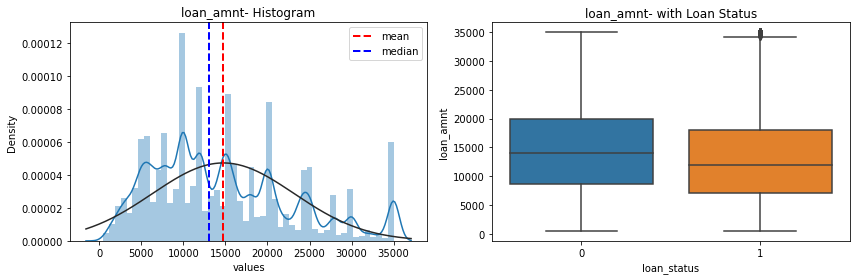

In [39]:
visualise_features(train_df,'loan_amnt','continous')

#### 7.1 Inferences:
    1.The defaulters and non-defaulters applied for apprx. same range of amount 10k to 20k dollars($)

#### 7.2 funded_amnt:
> loan_amnt	loan amount ($) sanctioned by the bank

In [40]:
summary_df[summary_df['Feature_Name']=='funded_amnt']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
1,funded_amnt,270000,8000.0,13000.0,20000.0,14736.266296,500.0,35000.0,70928515.73,8421.906894,0.681582,-0.254349,Moderately positively skewed,Mesokurtic,No Outliers


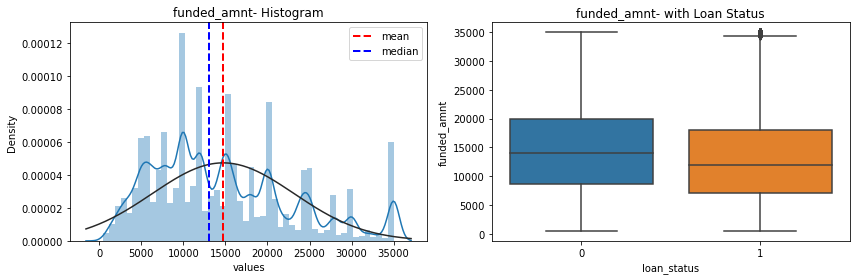

In [41]:
visualise_features(train_df,'funded_amnt','continous')

#### 7.2 Inferences:
    1.The defaulters and non-defaulters were sanctioned apprx. same range of amount 10k to 20k dollars($)

#### 7.3 funded_amnt_inv:
> loan amount ($) sanctioned by the investors

In [42]:
summary_df[summary_df['Feature_Name']=='funded_amnt_inv']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
2,funded_amnt_inv,270000,8000.0,13000.0,20000.0,14696.20653,0.0,35000.0,71142784.6,8434.618225,0.678673,-0.254581,Moderately positively skewed,Mesokurtic,No Outliers


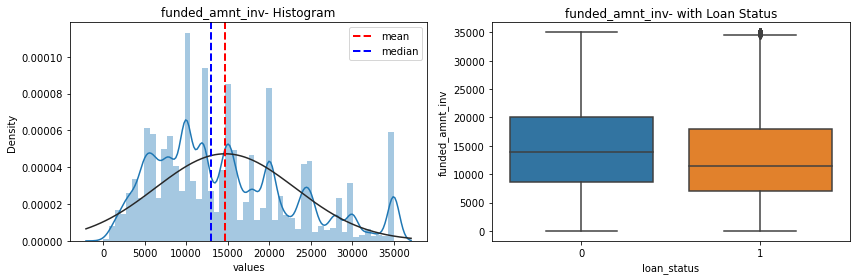

In [43]:
visualise_features(train_df,'funded_amnt_inv','continous')

#### 7.3 Inferences:
    1.The defaulters and non-defaulters were sanctioned apprx. same range of amount 10k to 20k dollars($)
    2.The 'Loan_amount', 'funded_amnt','funded_amnt_inv' all these cols look similar and convey the same information/
    3.Propbaby they are highly correlated.

#### 7.4 term:
> term	term of loan (in months)

In [44]:
summary_df[summary_df['Feature_Name']=='term']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
3,term,270000,36.0,36.0,60.0,43.203378,36.0,60.0,120.99,10.999676,0.872145,-1.239372,Moderately positively skewed,Platykurtic,No Outliers


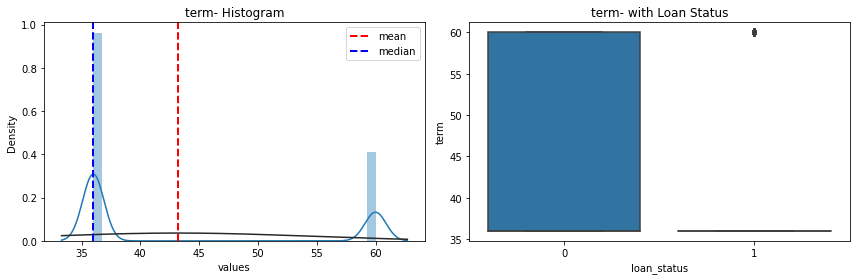

In [45]:
visualise_features(train_df,'term','continous')

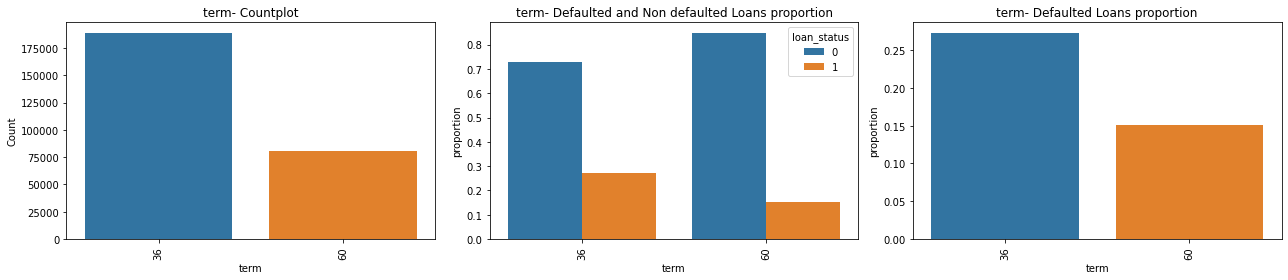

In [46]:
visualise_features(train_df,'term','discrete')

In [47]:
train_df['term'].value_counts(normalize=True)

36    0.699859
60    0.300141
Name: term, dtype: float64

In [48]:
train_df[['term','loan_status']].groupby('term').value_counts(normalize=True)

term  loan_status
36    0              0.726908
      1              0.273092
60    0              0.849231
      1              0.150769
dtype: float64

#### 7.4 Inferences:
    1.The min term is 3 years and max term is 5 years.
    2.The loans opted for 5 years have les % of defaulters as compared to loans opted for 3 years.

#### 7.5 term:
> Batch_enrolled
batch numbers allotted to members.
> **Batch number is irrelevant to the loan status**

#### 7.6 int_rate:
> interest rate (%) on loan

In [49]:
summary_df[summary_df['Feature_Name']=='int_rate']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
4,int_rate,270000,9.99,12.99,16.2,13.243335,5.32,28.99,19.18,4.379194,0.431118,-0.151731,Fairly positively skewed,Mesokurtic,Has Outliers


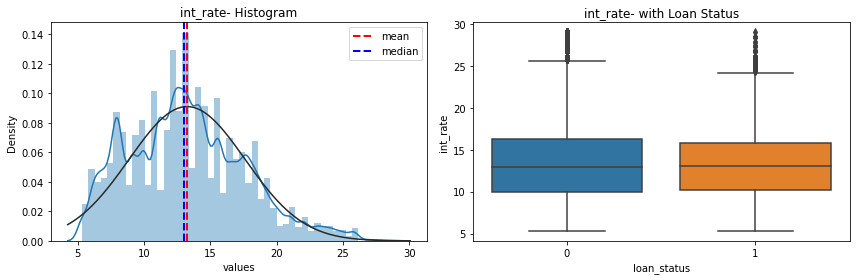

In [50]:
visualise_features(train_df,'int_rate','continous')

In [51]:
train_df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,13.239757,4.418093,5.32,9.99,12.99,16.29,28.99
1,63822.0,13.254895,4.251114,5.32,10.16,13.11,15.80,28.99


#### 7.6 inference:
> interest rate (%) for defaulted and non defaluted loans is similar. very less diff between the mean, median of defaulter 
and non defaulters
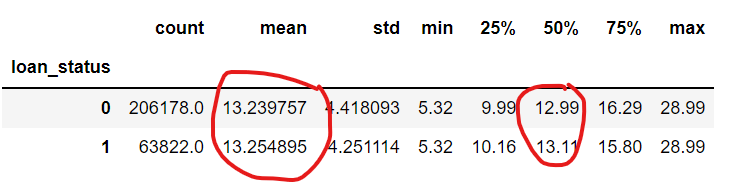

#### 7.7 grade:
> grade assigned by the bank

In [52]:
 train_df[['grade','loan_status']].groupby('grade').value_counts(normalize=True)

grade  loan_status
A      0              0.729312
       1              0.270688
B      0              0.736161
       1              0.263839
C      0              0.784693
       1              0.215307
D      0              0.782508
       1              0.217492
E      0              0.814399
       1              0.185601
F      0              0.790813
       1              0.209187
G      0              0.772616
       1              0.227384
dtype: float64

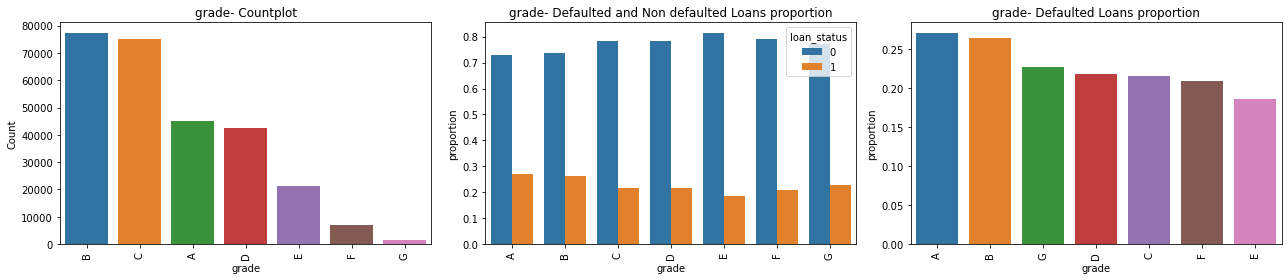

In [53]:
# plot_var(train_df,'grade')
visualise_features(train_df,'grade','discrete')

#### 7.7 inference:
    
> The columns A,B,G account for most of the defulters

#### 7.8 sub_grade:
> grade assigned by the bank

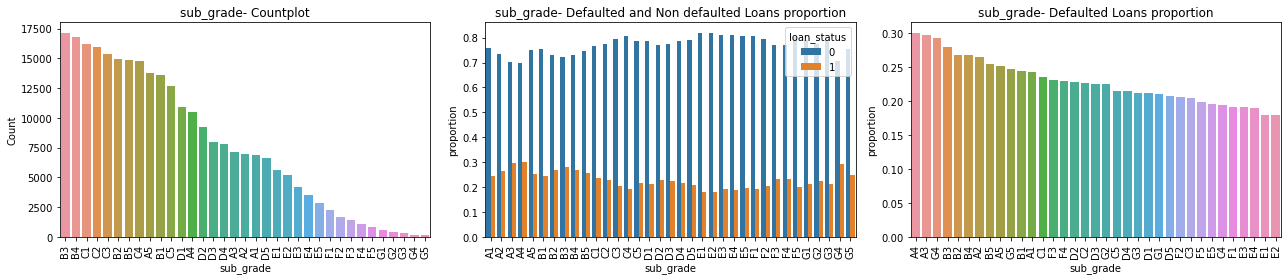

In [54]:
visualise_features(train_df,'sub_grade','discrete')

#### 7.8 inference:
    
> The subgrades with A,B,G account for most of the defulters

#### 7.9 emp_title:
> emp_title	job / Employer title of member

In [55]:
train_df[['emp_title','loan_status']].groupby('emp_title').value_counts(normalize=True).loc[:,1].sort_values(ascending=False)

emp_title
Other_profession    0.245022
Supervisor          0.142857
RN                  0.139988
Manager             0.135733
Project Manager     0.131225
Sales               0.127581
Registered Nurse    0.126888
Office Manager      0.125668
Teacher             0.120567
Driver              0.109735
Owner               0.062722
dtype: float64

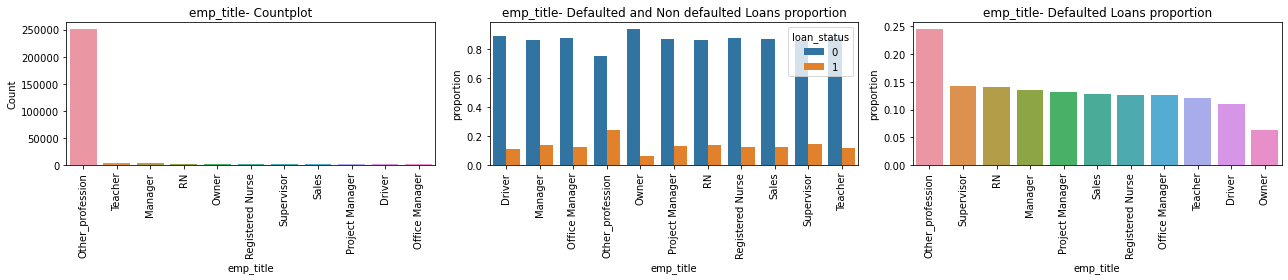

In [56]:
visualise_features(train_df,'emp_title','discrete')

#### 7.9 inference:
> in the supervisor,RN,Manager the defaulters are approx 13% to 14%

#### 7.10 emp_length:
> emp_length	employment length, where 0 means less than one year and 10 means ten or more years

In [57]:
summary_df[summary_df['Feature_Name']=='emp_length']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
5,emp_length,270000,3.0,6.0,10.0,6.083544,1.0,10.0,11.89,3.448048,-0.167241,-1.513038,Fairly negatively skewed,Platykurtic,No Outliers


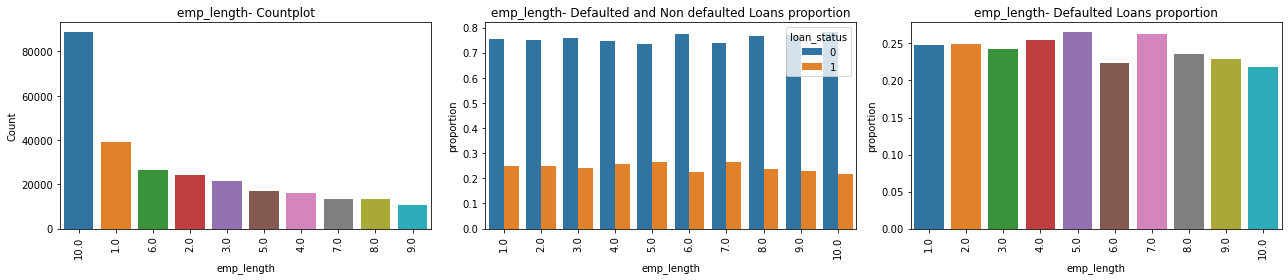

In [58]:
visualise_features(train_df,'emp_length','discrete')

#### 7.10 Inferences:
>There are more number of employees who worked for ~ 10 years
>The deaulters status is not affected by the employment length. In almost all the employee work duration length the defaulters are present and the proportions are more or less the same

#### 7.11 home_ownership
> status of home ownership

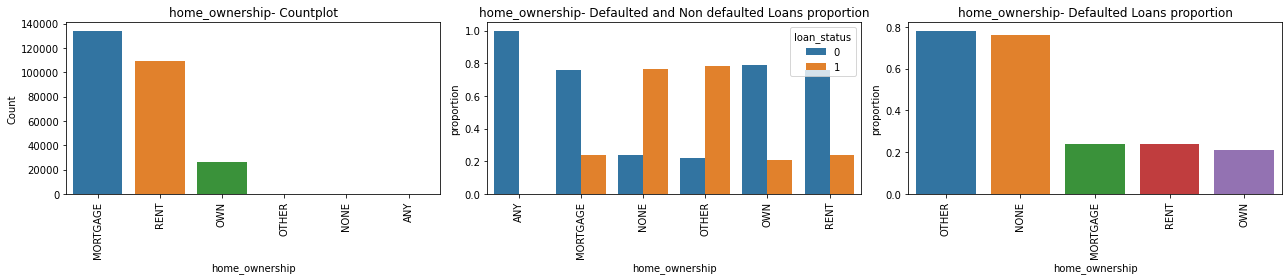

In [59]:
visualise_features(train_df,'home_ownership','discrete')

#replace the none and any category to other. They are also unknown categories

In [60]:
train_df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

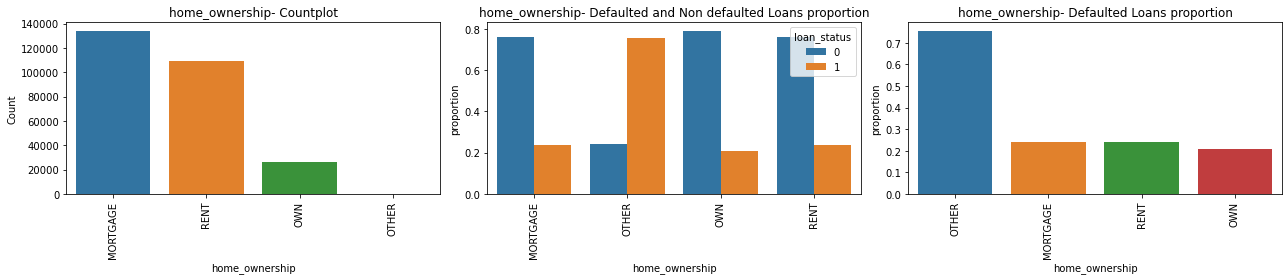

In [61]:
visualise_features(train_df,'home_ownership','discrete')

#### 7.10 Inferences:
>defaulters are more in the other category,
>followed by
>mortgage,
>rent.

#### 7.11 annual_inc: annual_inc	annual income ($) reported by the member

In [62]:
summary_df[summary_df['Feature_Name']=='annual_inc']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
6,annual_inc,270000,45000.0,64857.5,90000.0,75062.075324,1896.0,9500000.0,4.205805e+09,64852.177187,45.243898,5105.685412,Highly positively skewed,Leptokurtic,Has Outliers


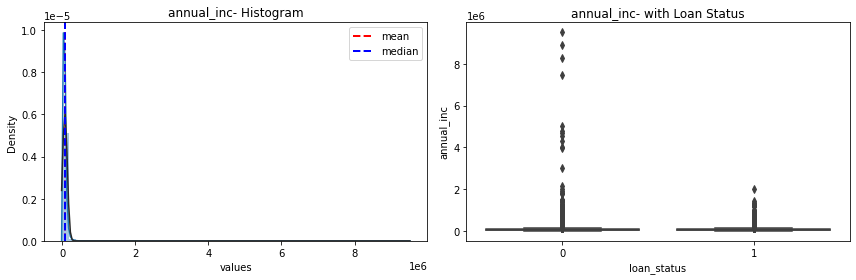

In [63]:
visualise_features(train_df,'annual_inc','continous')

> The annual income ranges from 1896.0($) to 9500000.0($)

    1.lets apply log transformation as the data looks right skewed.
    2.adding 1 to x there may be values of 0 and log10(0) would be infinity

In [64]:
train_df['log_annual_inc']=train_df['annual_inc'].apply(lambda x: np.log10(x+1))

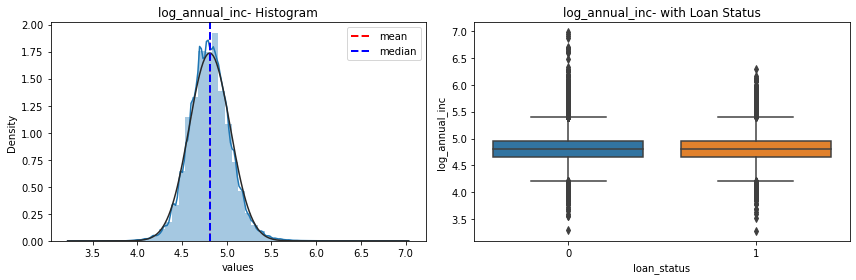

In [65]:
visualise_features(train_df,'log_annual_inc','continous')

In [66]:
train_df.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,4.810746,0.230719,3.301247,4.653222,4.812920,4.954247,6.977724
1,63822.0,4.806970,0.226116,3.278067,4.653222,4.806187,4.954247,6.301030


#### 7.11 pending inferences
> There are huge number of outliers in the data.
> after aplying the log transform there is no diff between the 0 and 1 class in loan status. the mean and median of both the classes is similar.

#### 7.12 verification_status:
verification status of income verified by the bank

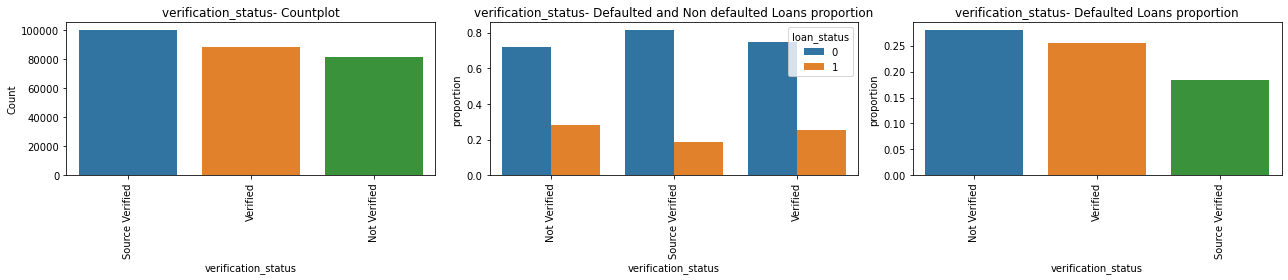

In [67]:
visualise_features(train_df,'verification_status','discrete')

#### 7.12 Inferences:
> wherever the status is not verified there are more chances of default

#### 7.13 pymnt_plan:
> indicates if any payment plan has started against loan

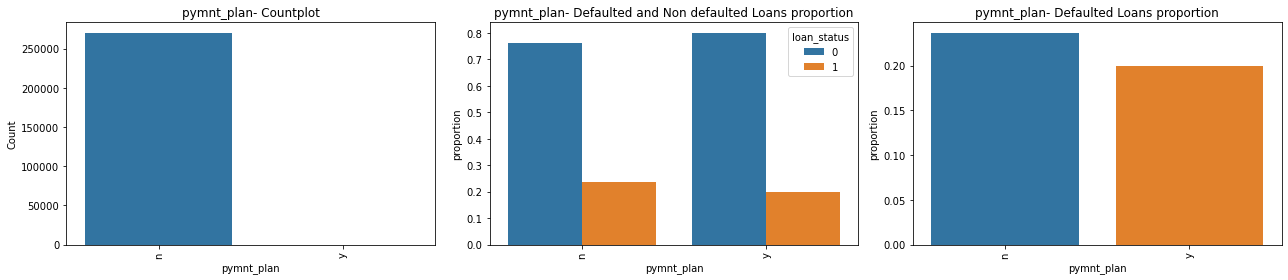

In [68]:
visualise_features(train_df,'pymnt_plan','discrete')

#### 7.13 inferences:
>This feature doesnt look useful to predict loan status.

#### 7.14 desc:
    1.loan description provided by member
    2. Not useful feature

#### 7.15: purpose	
purpose of loan

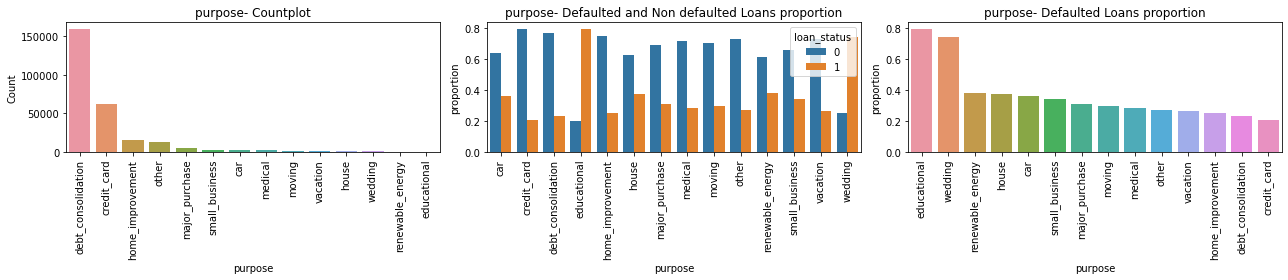

In [69]:
visualise_features(train_df,'purpose','discrete')

In [70]:
train_df[['purpose','loan_status']].groupby('purpose').value_counts(normalize=True)

purpose             loan_status
car                 0              0.638899
                    1              0.361101
credit_card         0              0.794038
                    1              0.205962
debt_consolidation  0              0.768054
                    1              0.231946
educational         1              0.798387
                    0              0.201613
home_improvement    0              0.747987
                    1              0.252013
house               0              0.624422
                    1              0.375578
major_purchase      0              0.691112
                    1              0.308888
medical             0              0.718289
                    1              0.281711
moving              0              0.702077
                    1              0.297923
other               0              0.729482
                    1              0.270518
renewable_energy    0              0.617647
                    1              0.382353


#### 7.15 inference:
The reason provided by the customer to take the loan.
The loans taken for educational purpose,wedding have high chances of default.

#### 7.16: title	
    1.loan title provided by member

In [71]:
train_df[['title']].value_counts()

title                         
Debt consolidation                142342
Credit card refinancing            49834
Home improvement                   12086
Other                               9615
Major purchase                      3682
                                   ...  
Home Improvement & Pay Bills           1
Home Improvement & Storage             1
Home Improvement (room add-on)         1
Home Improvement - After Sandy         1
zonball Loan                           1
Length: 18455, dtype: int64

In [72]:
train_df[['title']].describe()

,title
count,270000
unique,18455
top,Debt consolidation
freq,142342


#### 7.16 Inferences:
The purpose column is a super set of this column. redundant info
there are 18455 uinique entries in it and as it is like a subset of pupose  it can bo dropped.

#### 7.17 zip_code:
zip_code	first three digits of area zipcode of member

In [73]:
train_df['zip_code'].nunique()

895

#### 7.18 addr_state
living state of member

In [74]:
train_df['addr_state'].nunique()

51

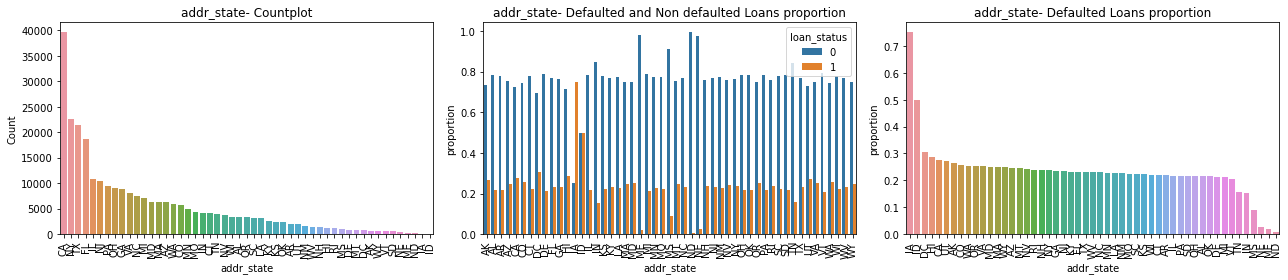

In [75]:
visualise_features(train_df,'addr_state','discrete')

In [76]:
add_df=train_df[['addr_state','loan_status']].groupby('addr_state',as_index=False).value_counts(normalize=True)

In [77]:
add_df[add_df['loan_status']==1].sort_values(by='proportion',ascending=False)

,addr_state,loan_status,proportion
24,IA,1,0.750000
26,ID,1,0.500000
15,DC,1,0.305292
23,HI,1,0.287471
9,CA,1,0.277515
89,UT,1,0.271865
1,AK,1,0.266176
11,CO,1,0.256926
95,WA,1,0.255080
75,OR,1,0.253309


#### 7.18 Inference
    1. The state and zip code both are similar info but the unique values in zip code are huge.
    2. we can use state and drop zip

#### 7.19: dti

    1.The debt-to-income (DTI) ratio reflects an individual's monthly loan payment to their monthly gross income. Your gross earnings is the amount you earn without taxes and additional deductions. The debt-to-income ratio is the proportion of your monthly gross income that goes toward debt payments.
    2.The debt-to-income ratio formula is:
    3.DTI ratio = Total monthly debt payments/Gross monthly income X 100
    where: Total monthly debt payments are the aggregate of the monthly EMIs, including credit card payments. The gross monthly income is the sum of your monthly earnings.

In [78]:
 summary_df[summary_df['Feature_Name']=='dti']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
8,dti,270000,11.91,17.63,23.94,18.128041,0.0,137.4,69.01,8.307225,0.260178,-0.224051,Fairly positively skewed,Mesokurtic,Has Outliers


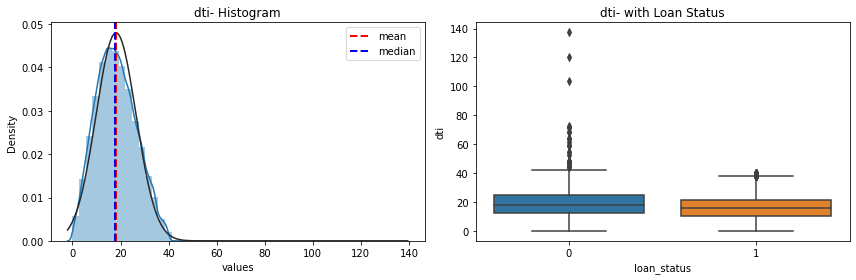

In [79]:
visualise_features(train_df,'dti','continous')

In [80]:
train_df.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,18.751314,8.387706,0.0,12.44,18.27,24.71,137.40
1,63822.0,16.114549,7.704621,0.0,10.39,15.71,21.45,39.96


#### 7.19 Inference:
There are many outliers. Need to treat the column.
The mean and median for the defaulter and non defaulter are close by.

#### 7.20 delinq_2yrs: number of 30+ days delinquency in past 2 years
    1.Delinquency occurs as soon as a borrower misses a payment on a loan, which can affect their credit score.
    2.Delinquency rates are used to show how many accounts in a financial institution's portfolio are delinquent.
    3.Consistently delinquent borrowers end up in default.

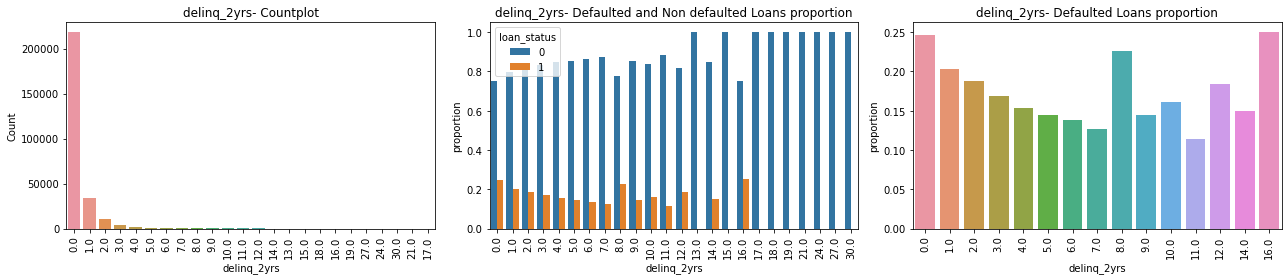

In [81]:
visualise_features(train_df,'delinq_2yrs','discrete')

In [82]:
delinq=train_df[['delinq_2yrs','loan_status']].groupby('delinq_2yrs',as_index=False).value_counts(normalize=True)

In [83]:
delinq[delinq['loan_status']==1].sort_values(by='proportion',ascending=False)

,delinq_2yrs,loan_status,proportion
31,16.0,1,0.250000
1,0.0,1,0.246513
17,8.0,1,0.225564
3,1.0,1,0.202713
5,2.0,1,0.188246
25,12.0,1,0.184211
7,3.0,1,0.168740
21,10.0,1,0.161290
9,4.0,1,0.154086
28,14.0,1,0.150000


##### 7.20 delinq_2yrs: 
There is no specific pattern of loan_status with delinq_2yrs. as the no of delinquecy increase we cant exactly say that the person defaults

#### 7.21 inq_last_6mths
number of inquiries in last 6 months
multiple credit inquiries do have an adverse impact on consumer credit scores and thus they represent significant credit risk, often prompting rejection.

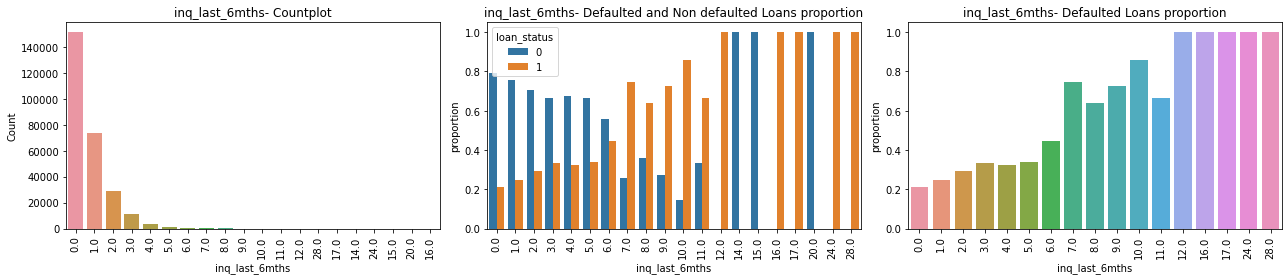

In [84]:
visualise_features(train_df,'inq_last_6mths','discrete')

#### 7.21 Inference:
    As the number of inqueries increase the defaulter proprtion also increases

#### 7.22 mths_since_last_delinq
    number of months since last delinq

In [85]:
summary_df[summary_df['Feature_Name']=='mths_since_last_delinq']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
11,mths_since_last_delinq,270000,31.0,31.0,31.0,32.462915,0.0,176.0,234.81,15.323568,0.941266,1.792524,Moderately positively skewed,Leptokurtic,Has Outliers


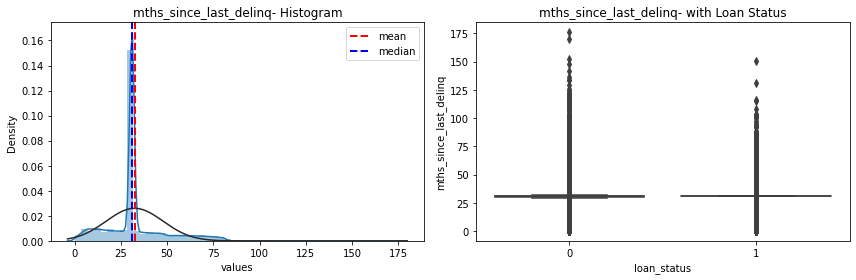

In [86]:
visualise_features(train_df,'mths_since_last_delinq','continous')

In [87]:
train_df[['mths_since_last_delinq','loan_status']].groupby('mths_since_last_delinq').value_counts()

mths_since_last_delinq  loan_status
0.0                     0               292
                        1               212
1.0                     0               820
                        1               157
2.0                     0              1018
                                       ... 
148.0                   0                 1
151.0                   1                 1
152.0                   0                 1
170.0                   0                 1
176.0                   0                 1
Length: 231, dtype: int64

In [88]:
train_df['log_mths_since_last_delinq']=train_df['mths_since_last_delinq'].apply(lambda x: np.log10(x+1))

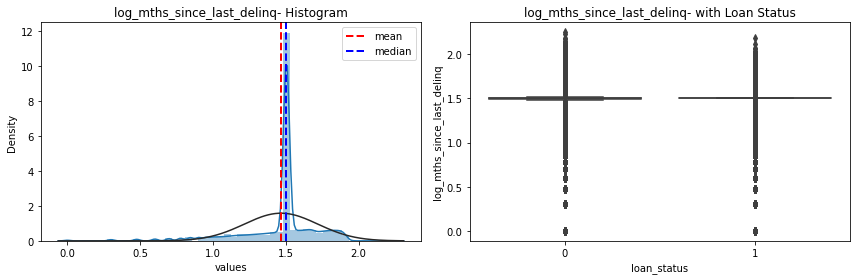

In [89]:
visualise_features(train_df,'log_mths_since_last_delinq','continous')

#### 7.22 Inferences
    1.There are many number of outliers
    2.The visual plot doesnt give clear idea of the loan_status vs mnths since last delinq

#### 7.23 mths_since_last_record
    number of months since last public record

In [90]:
summary_df[summary_df['Feature_Name']=='mths_since_last_record']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
12,mths_since_last_record,270000,70.0,70.0,70.0,70.000915,0.0,121.0,121.51,11.023297,-0.514263,12.751423,Moderately Negatively skewed,Leptokurtic,Has Outliers


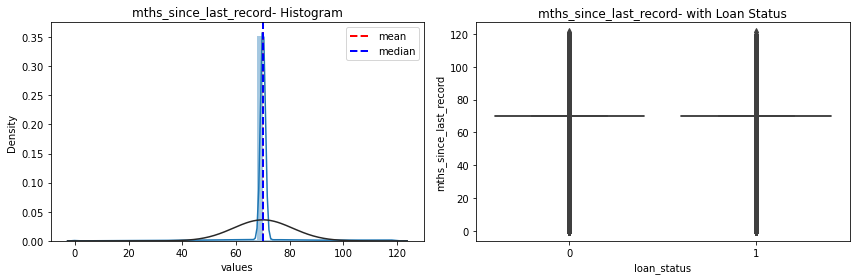

In [91]:
visualise_features(train_df,'mths_since_last_record','continous')

In [92]:
train_df['mths_since_last_record'].nunique()

122

In [93]:
train_df['mths_since_last_record'].value_counts()

70.0     229264
62.0        599
61.0        599
69.0        595
75.0        588
          ...  
3.0          41
1.0          25
2.0          16
120.0         5
121.0         2
Name: mths_since_last_record, Length: 122, dtype: int64

##### 7.23 Inferences
1.There are many number of outliers
2.The visual plot doesnt give clear idea of the loan_status vs mths_since_last_record
3.mths_since_last_record doesnt look useful to predict loan status

#### 7.24 open_acc
    number of open credit line in member's credit line

In [94]:
 summary_df[summary_df['Feature_Name']=='open_acc']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
13,open_acc,270000,8.0,11.0,14.0,11.55,0.0,79.0,28.34,5.323457,1.256553,3.128307,Highly positively skewed,Leptokurtic,Has Outliers


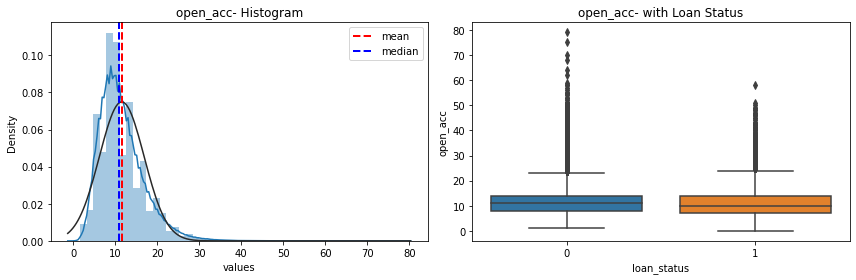

In [95]:
visualise_features(train_df,'open_acc','continous')

In [96]:
train_df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,11.739943,5.437548,1.0,8.0,11.0,14.0,79.0
1,63822.0,10.936386,4.886746,0.0,7.0,10.0,14.0,58.0


#### 7.24 Inference
    1.There is no significant difference between the loan status 0 and 1 wrt to open_acc feature.

#### 7.25 pub_rec
    number of derogatory public records
    Public records come from government documents. A public record with adverse information could indicate you stopped paying your debt, which could crush your credit.

In [97]:
summary_df[summary_df['Feature_Name']=='pub_rec']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
14,pub_rec,270000,0.0,0.0,0.0,0.193281,0.0,49.0,0.32,0.569066,8.596114,306.588134,Highly positively skewed,Leptokurtic,Has Outliers


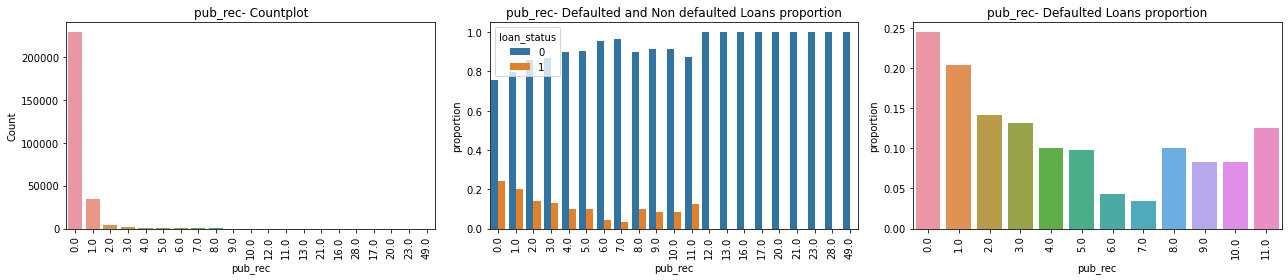

In [98]:
visualise_features(train_df,'pub_rec','discrete')

In [99]:
train_df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,0.208839,0.604703,0.0,0.0,0.0,0.0,49.0
1,63822.0,0.143023,0.430582,0.0,0.0,0.0,0.0,11.0


##### 7.25 Inferences:
    1.The variance in this col is very less.
    2.There is diff between the avg pub_rec and loan status.
    3.The loan status cant be judged as the number of public records increases.

#### 7.26 revol_bal
    total credit revolving balance
    
    If you’re approved for a revolving credit account, like a credit card, the lender will set a credit limit. The credit limit is the maximum amount you can charge to that account. When you make a purchase, you’ll have less available credit. And every time you make a payment, your available credit goes back up.

    Revolving credit accounts are open ended, meaning they don’t have an end date. As long as the account remains open and in good standing, you can continue to use it. Keep in mind that your minimum payment might vary from month to month because it’s often calculated based on how much you owe at that time. 

    What Is a Revolving Balance?
    If you don’t pay the balance on your revolving credit account in full every month, the unpaid portion carries over to the next month. That’s called a revolving balance. 

    You might apply for credit assuming you’ll always pay your balance in full every month. But real life can get in the way. Cars break down. Doctors’ appointments come up. And if you can’t pay your full balance, you’ll find yourself carrying a revolving balance to the following month. 

In [100]:
summary_df[summary_df['Feature_Name']=='revol_bal']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
15,revol_bal,270000,6451.0,11900.0,20861.0,16912.038519,0.0,2560703.0,4.824580e+08,21964.927297,14.745967,868.295938,Highly positively skewed,Leptokurtic,Has Outliers


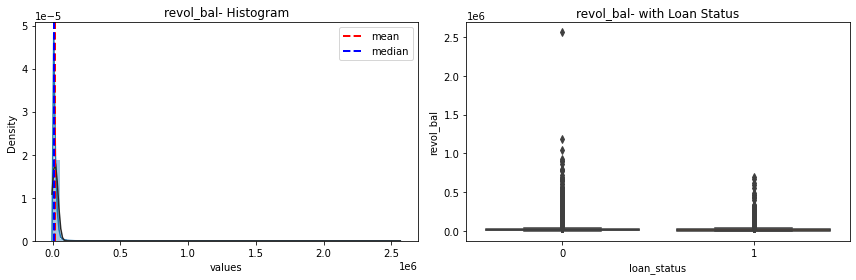

In [101]:
visualise_features(train_df,'revol_bal','continous')

In [102]:
#lets check the plot after applying log transformation
#since the data is highly right skewed chosed to apply log transform

In [103]:
train_df['log_revol_bal']=train_df['revol_bal'].apply(lambda x: np.log10(x+1))
#adding 1 to x since there are many revol_bal with 0 as input and log 0 would be infinity

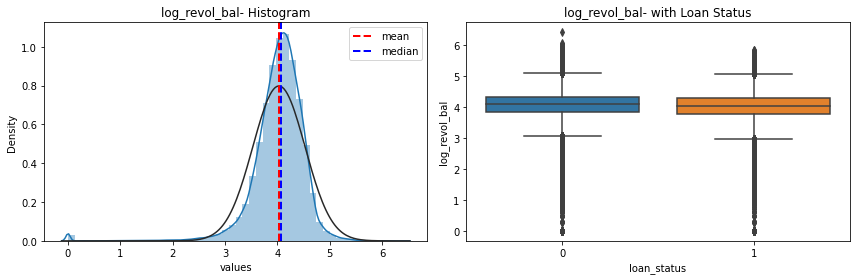

In [104]:
visualise_features(train_df,'log_revol_bal','continous')

In [105]:
# By the visual it looks like the log revol bal doesnt differentiate the loan status 0 and 1

In [106]:
train_df.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,4.049140,0.473053,0.0,3.825491,4.087994,4.331199,6.408359
1,63822.0,3.961022,0.572606,0.0,3.759743,4.033866,4.278656,5.841745


#### 7.26 Inferences:
    1. The revol_bal is having many outliers.
    2. The min balance is 0.0 and max is 2560703.0 ($)
    3. After working with the log transform there seems to be hardly any diff between the means of both the classes 0 and 1 

#### 7.27 revol_util:
    1.amount of credit a member is using relative to revol_bal
    2.Your credit utilization ratio—sometimes called revolving utilization—is how much available credit you have 
    compared with the amount of credit you’re using.
    3.According to the CFPB, you can calculate your credit utilization ratio by dividing your total balances across all of your accounts by your total credit limit.

In [107]:
summary_df[summary_df['Feature_Name']=='revol_util']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
16,revol_util,270000,37.7,56.0,73.6,55.068662,0.0,892.3,570.1,23.876852,-0.017092,4.865157,Fairly negatively skewed,Leptokurtic,Has Outliers


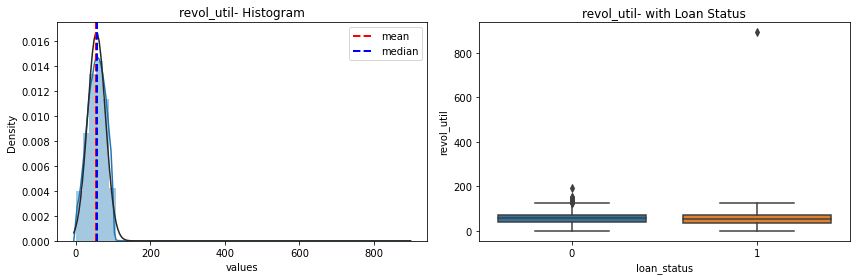

In [108]:
visualise_features(train_df,'revol_util','continous')

In [109]:
train_df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,55.706531,23.456373,0.0,38.5,56.5,73.9,193.0
1,63822.0,53.008014,25.076857,0.0,34.7,54.3,72.6,892.3


#### 7.27 Inference:
1.The difference between means of both the classes is less. This feature doesnt differentiate both the classes.

#### 7.28: total_acc
    1.total number of credit lines available in members credit line.
    2.A line of credit (LOC) is a preset borrowing limit that can be tapped into at any time. The borrower can take money out as needed until the limit is reached. As money is repaid, it can be borrowed again in the case of an open line of credit.
    3.An LOC is an arrangement between a financial institution—usually a bank—and a customer that establishes the maximum loan amount that the customer can borrow. The borrower can access funds from the LOC at any time as long as they do not exceed the maximum amount (or credit limit) set in the agreement.

In [110]:
summary_df[summary_df['Feature_Name']=='total_acc']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
17,total_acc,270000,17.0,24.0,32.0,25.254933,1.0,138.0,140.45,11.851032,0.893654,1.315517,Moderately positively skewed,Leptokurtic,Has Outliers


In [111]:
train_df['total_acc'].nunique()

114

##### many unique credit line difficult to plot

In [112]:
train_df.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,25.268055,11.871131,1.0,17.0,24.0,32.0,138.0
1,63822.0,25.212544,11.785862,1.0,17.0,24.0,32.0,104.0


#### 7.28 Inference:
    1.There is no difference between the means of both the classes

#### 7.29 initial_list_status:
unique listing status of the loan - W(Waiting), F(Forwarded)

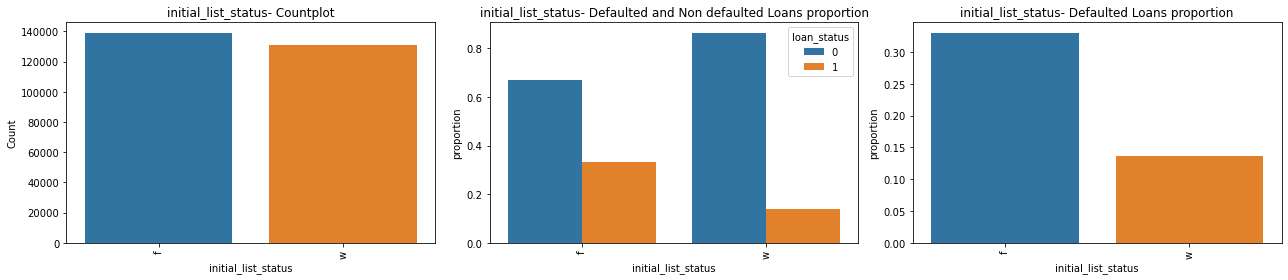

In [113]:
visualise_features(train_df,'initial_list_status','discrete')

#### 7.29 Inference:
    1. The forwarded list have more defaulters as compared to waiting list

#### 7.30 total_rec_int:
interest received till date

In [114]:
summary_df[summary_df['Feature_Name']=='total_rec_int']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
18,total_rec_int,270000,441.38,1072.615,2229.7225,1751.244025,0.0,24205.62,4379309.16,2092.6799,2.852667,11.877372,Highly positively skewed,Leptokurtic,Has Outliers


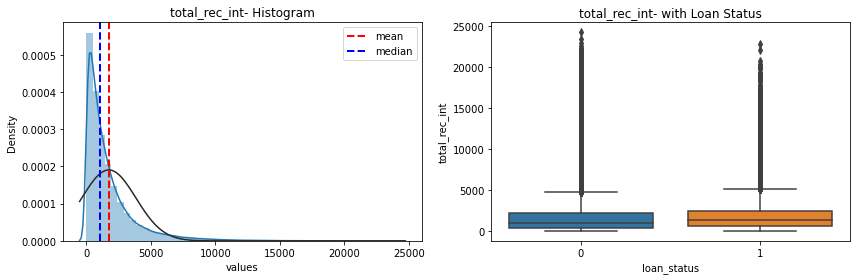

In [115]:
visualise_features(train_df,'total_rec_int','continous')

In [116]:
train_df.groupby('loan_status')['total_rec_int'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,1707.425737,2118.690138,0.0,395.165,1000.72,2157.8300,24205.62
1,63822.0,1892.799709,1999.816528,0.0,619.585,1289.26,2418.3225,22777.58


In [117]:
train_df['log_total_rec_int']=train_df['total_rec_int'].apply(lambda x : np.log10(x+1))

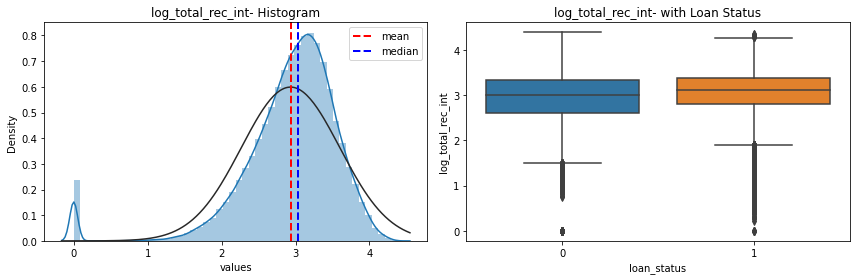

In [118]:
visualise_features(train_df,'log_total_rec_int','continous')

In [119]:
train_df.groupby('loan_status')['log_total_rec_int'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,2.894766,0.706578,0.0,2.597876,3.000746,3.334218,4.383934
1,63822.0,3.055748,0.493680,0.0,2.792801,3.110677,3.383694,4.357527


#### 7.30 inference:
    1. There is no substantial difference between the classes with this feature

#### 7.31 total_rec_late_fee:
Late fee received till date

In [120]:
summary_df[summary_df['Feature_Name']=='total_rec_late_fee']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
19,total_rec_late_fee,270000,0.0,0.0,0.0,0.402963,0.0,358.68,17.82,4.220959,18.739246,622.052145,Highly positively skewed,Leptokurtic,Has Outliers


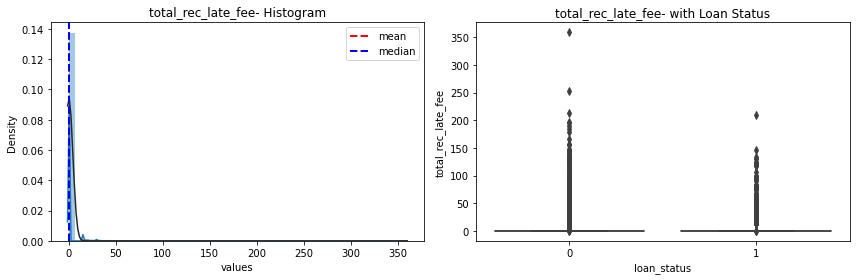

In [121]:
visualise_features(train_df,'total_rec_late_fee','continous')

In [122]:
train_df.groupby('loan_status')['total_rec_late_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,0.412139,4.314994,0.0,0.0,0.0,0.0,358.68000
1,63822.0,0.373319,3.901607,0.0,0.0,0.0,0.0,208.81953


#### 7.31 Inference:
    1.There is no substantial difference between the classes with this feature

#### 7.32 recoveries:
post charge off gross recovery

In [123]:
summary_df[summary_df['Feature_Name']=='recoveries']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
20,recoveries,270000,0.0,0.0,0.0,45.419585,0.0,29623.35,158026.79,397.52584,16.020333,459.405876,Highly positively skewed,Leptokurtic,Has Outliers


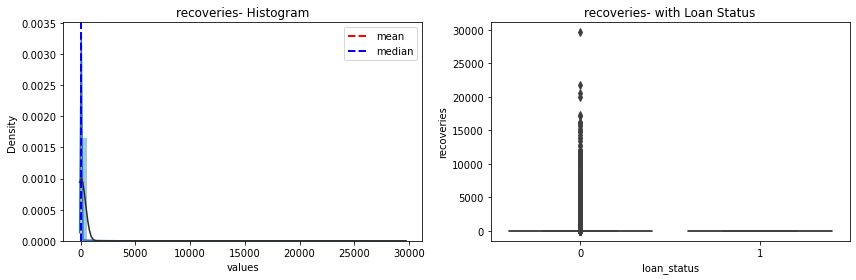

In [124]:
visualise_features(train_df,'recoveries','continous')

In [125]:
train_df.groupby('loan_status')['recoveries'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,59.47913,453.99082,0.0,0.0,0.0,0.0,29623.35
1,63822.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00


#### 7.32 Inference:
    1. Almost all the values are centered near zero.
    2. This feature dosnt differentiate both the classes.

#### 7.33 collection_recovery_fee:
    1.post charge off collection fee

In [126]:
summary_df[summary_df['Feature_Name']=='collection_recovery_fee']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
21,collection_recovery_fee,270000,0.0,0.0,0.0,4.805591,0.0,7002.19,3645.88,60.381161,27.585743,1622.315039,Highly positively skewed,Leptokurtic,Has Outliers


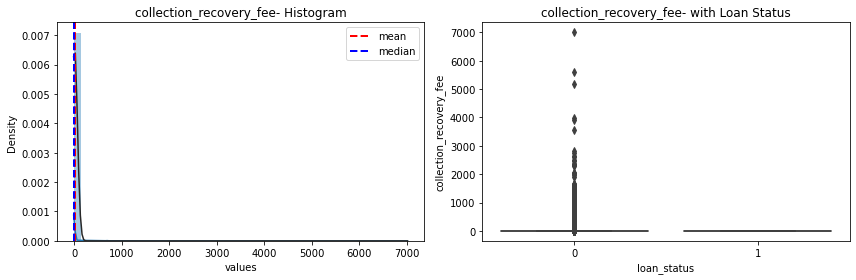

In [127]:
visualise_features(train_df,'collection_recovery_fee','continous')

In [128]:
train_df.groupby('loan_status')['collection_recovery_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,6.293152,69.02974,0.0,0.0,0.0,0.0,7002.19
1,63822.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00


#### 7.33 Inference:
    1. most data is centereda round zero
    not useful for classifying

#### 7.34 collections_12_mths_ex_med:
    1.number of collections in last 12 months excluding medical collections

In [129]:
summary_df[summary_df['Feature_Name']=='collections_12_mths_ex_med']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
22,collections_12_mths_ex_med,270000,0.0,0.0,0.0,0.014259,0.0,16.0,0.02,0.13346,16.792144,929.28385,Highly positively skewed,Leptokurtic,Has Outliers


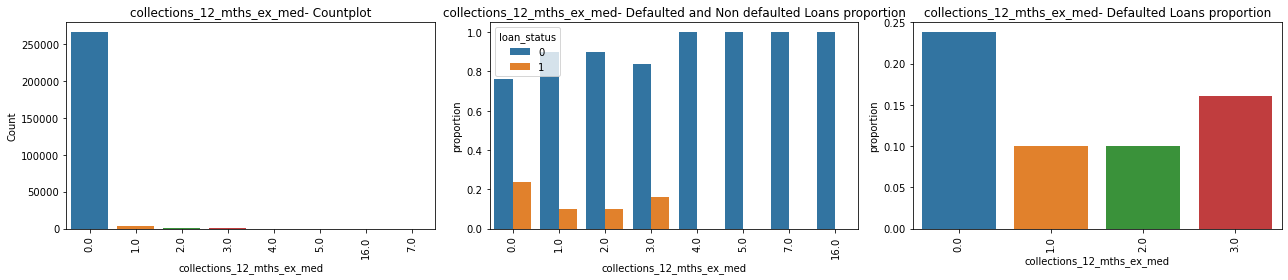

In [130]:
visualise_features(train_df,'collections_12_mths_ex_med','discrete')

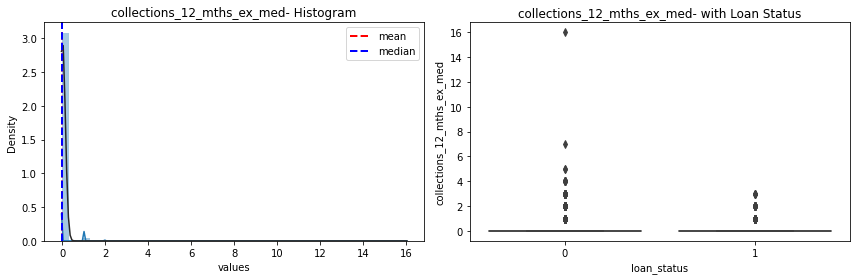

In [131]:
visualise_features(train_df,'collections_12_mths_ex_med','continous')

In [132]:
train_df.groupby('loan_status')['collections_12_mths_ex_med'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,0.016801,0.145249,0.0,0.0,0.0,0.0,16.0
1,63822.0,0.006048,0.084311,0.0,0.0,0.0,0.0,3.0


#### 7.34 Inference:
    1.This feature doesnt differentiate between both the classes

#### 7.35 mths_since_last_major_derog:
    1.months since most recent 90 day or worse rating
    “Derogatory” is seen as negative to lenders, and can include late payments, collection accounts, bankruptcy, charge-offs and other negative marks on your credit report. This can impact your ability to qualify for new credit.

In [133]:
summary_df[summary_df['Feature_Name']=='mths_since_last_major_derog']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
23,mths_since_last_major_derog,270000,44.0,44.0,44.0,44.014659,0.0,176.0,122.91,11.086417,0.547339,8.819535,Moderately positively skewed,Leptokurtic,Has Outliers


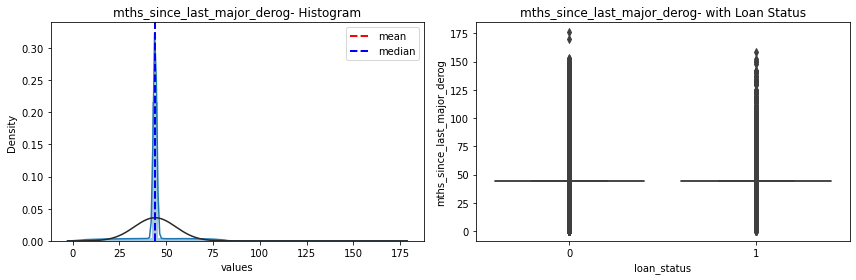

In [134]:
visualise_features(train_df,'mths_since_last_major_derog','continous')

#### 7.35 Inference:
1.This feature doesnt differentiate between both the classes

#### 7.36 application_type:
indicates when the member is an individual or joint

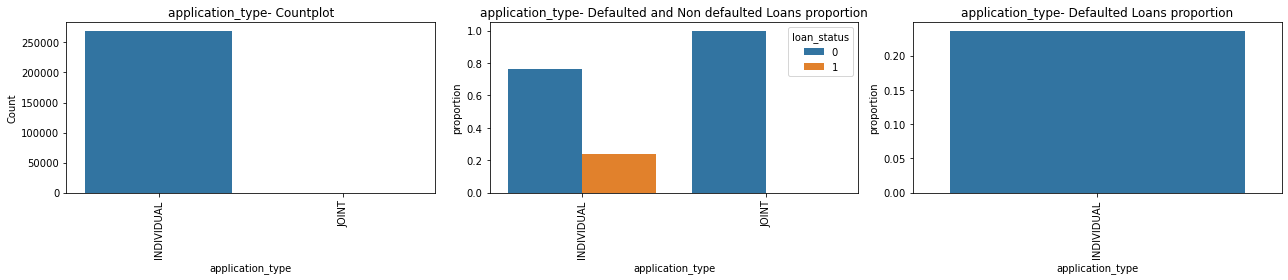

In [135]:
visualise_features(train_df,'application_type','discrete')

#### 7.36 Inference:
    1.Individual loans are more prone to defaulting

#### 7.37 verification_status_joint: Deleted since most of the entries were null

#### 7.38 last_week_pay
indicates how long (in weeks) a member has paid EMI after batch enrolled

In [136]:
summary_df[summary_df['Feature_Name']=='last_week_pay']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
24,last_week_pay,270000,22.0,48.0,83.0,57.919267,0.0,300.0,1929.09,43.921408,1.034416,0.807722,Highly positively skewed,Mesokurtic,Has Outliers


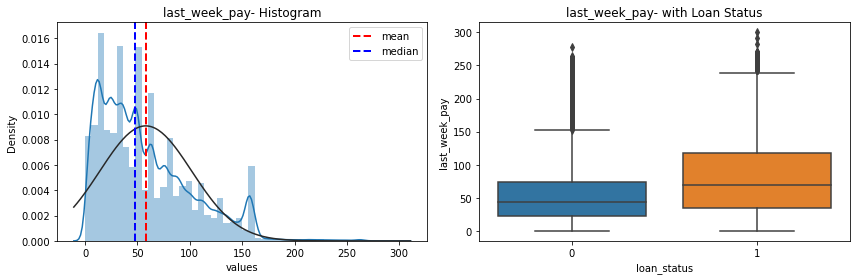

In [137]:
visualise_features(train_df,'last_week_pay','continous')

In [138]:
train_df.groupby('loan_status')['last_week_pay'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,51.551596,38.889805,0.0,22.0,43.0,74.0,278.0
1,63822.0,78.490129,52.163652,0.0,35.0,69.0,117.0,300.0


#### Inference:
    1.there are more defaulters in when the no of weeks is more.

#### 7.40 acc_now_delinq
number of accounts on which the member is delinquent

In [139]:
summary_df[summary_df['Feature_Name']=='acc_now_delinq']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
25,acc_now_delinq,270000,0.0,0.0,0.0,0.00493,0.0,5.0,0.01,0.076894,19.496813,541.919393,Highly positively skewed,Leptokurtic,Has Outliers


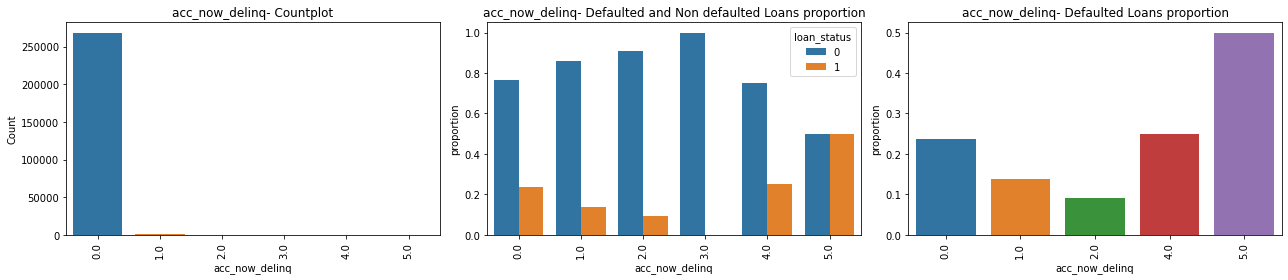

In [140]:
visualise_features(train_df,'acc_now_delinq','discrete')

#### 7.40 Inference:
    1.The variance of this column is very less 
    2. Most of the data have entry as 0.
    3.Not useful to classify the loan_status

#### 7.41 tot_coll_amt:
total collection amount ever owed

In [141]:
summary_df[summary_df['Feature_Name']=='tot_coll_amt']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
26,tot_coll_amt,270000,0.0,0.0,0.0,197.023778,0.0,496651.0,3797256.98,1948.655172,81.955557,16838.18932,Highly positively skewed,Leptokurtic,Has Outliers


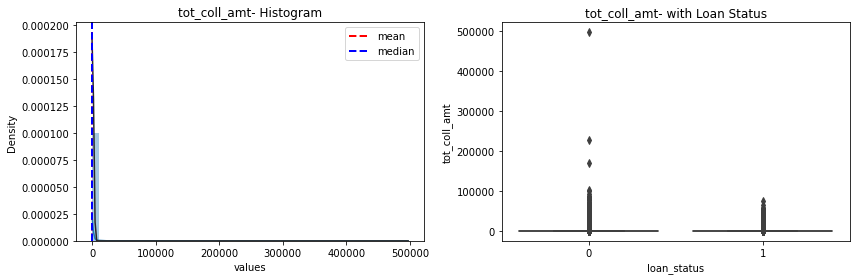

In [142]:
visualise_features(train_df,'tot_coll_amt','continous')

In [143]:
train_df.groupby('loan_status')['tot_coll_amt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,219.131896,2102.867234,0.0,0.0,0.0,0.0,496651.0
1,63822.0,125.603146,1331.243320,0.0,0.0,0.0,0.0,75081.0


#### 7.41 Inferences:

    1. Most of the data have entry as 0.
    2.Not useful to classify the loan_status

#### 7.42 tot_cur_bal:
total current balance of all accounts

In [144]:
summary_df[summary_df['Feature_Name']=='tot_cur_bal']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
27,tot_cur_bal,270000,32171.0,80335.0,195986.25,134838.58143,0.0,3840795.0,2.184540e+10,147801.879323,2.747057,17.986792,Highly positively skewed,Leptokurtic,Has Outliers


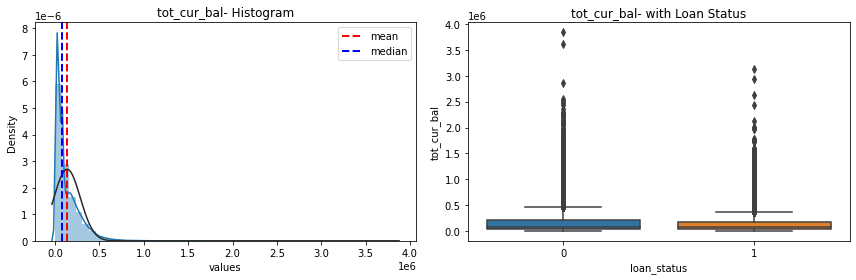

In [145]:
visualise_features(train_df,'tot_cur_bal','continous')

In [146]:
train_df['log_tot_cur_bal']=train_df['tot_cur_bal'].apply(lambda x: np.log10(x+1))

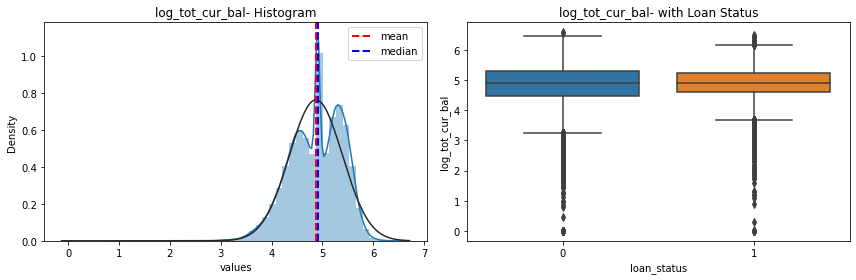

In [147]:
visualise_features(train_df,'log_tot_cur_bal','continous')

In [148]:
train_df.groupby('loan_status')['log_tot_cur_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,4.869571,0.533165,0.0,4.484858,4.90491,5.307736,6.584421
1,63822.0,4.884635,0.483972,0.0,4.615047,4.90491,5.232675,6.495383


#### 7.42 Inferences:
    1.The means for both the classes are same.
    2.Not useful to classify the loan_status.

#### 7.43 total_rev_hi_lim
total revolving credit limit

In [149]:
summary_df[summary_df['Feature_Name']=='total_rev_hi_lim']

,Feature_Name,Count,Q1,Q2,Q3,mean,min,max,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
28,total_rev_hi_lim,270000,14700.0,23800.0,38000.0,31420.347526,0.0,9999999.0,1.308518e+09,36173.444006,81.309873,21413.910625,Highly positively skewed,Leptokurtic,Has Outliers


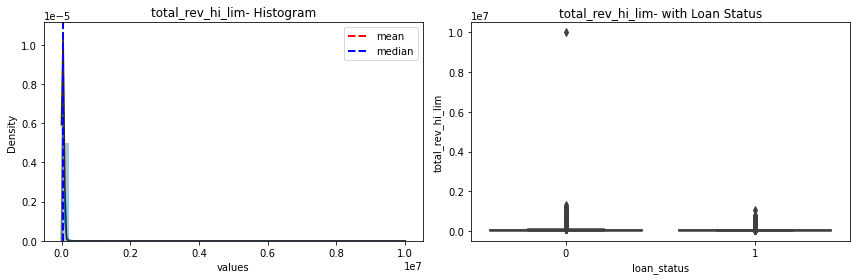

In [150]:
visualise_features(train_df,'total_rev_hi_lim','continous')

In [151]:
train_df['log_total_rev_hi_lim']=train_df['total_rev_hi_lim'].apply(lambda x: np.log10(x+1))

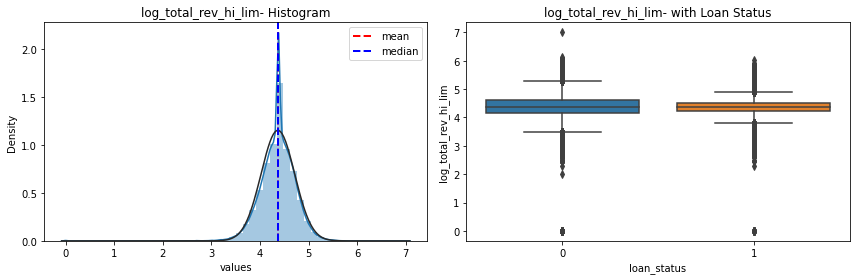

In [152]:
visualise_features(train_df,'log_total_rev_hi_lim','continous')

In [153]:
train_df.groupby('loan_status')['log_total_rev_hi_lim'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,206178.0,4.369623,0.357694,0.0,4.155366,4.376595,4.600984,7.000000
1,63822.0,4.355994,0.304199,0.0,4.220134,4.376595,4.492774,6.013048


#### 7.43 Inferences:
    1.The means for both the classes are same.
    2.Not useful to classify the loan_status.

In [154]:
backup_train_df=train_df

In [155]:
backup_train_df.to_csv('train_df_processed.csv')

In [156]:
backup_test_df=test_df
backup_test_df.to_csv('test_df_processed.csv')

In [157]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    270000 non-null  int64  
 1   funded_amnt                  270000 non-null  int64  
 2   funded_amnt_inv              270000 non-null  float64
 3   term                         270000 non-null  int64  
 4   int_rate                     270000 non-null  float64
 5   grade                        270000 non-null  object 
 6   sub_grade                    270000 non-null  object 
 7   emp_title                    270000 non-null  object 
 8   emp_length                   270000 non-null  float64
 9   home_ownership               270000 non-null  object 
 10  annual_inc                   270000 non-null  float64
 11  verification_status          270000 non-null  object 
 12  pymnt_plan                   270000 non-null  object 
 13 

In [158]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262428 entries, 0 to 262427
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    262428 non-null  int64  
 1   funded_amnt                  262428 non-null  int64  
 2   funded_amnt_inv              262428 non-null  float64
 3   term                         262428 non-null  int64  
 4   int_rate                     262428 non-null  float64
 5   grade                        262428 non-null  object 
 6   sub_grade                    262428 non-null  object 
 7   emp_title                    262428 non-null  object 
 8   emp_length                   262428 non-null  float64
 9   home_ownership               262428 non-null  object 
 10  annual_inc                   262428 non-null  float64
 11  verification_status          262428 non-null  object 
 12  pymnt_plan                   262428 non-null  object 
 13 

> All the features are analysed in the EDA and the features which donot contribute to predicting Y target variable are selected and dropped

In [159]:
#drop the numeric features which donot differentiate both the classes
train_df.drop(['revol_bal','annual_inc','total_rec_int' ,'tot_cur_bal' ,'total_rev_hi_lim','mths_since_last_delinq'],axis=1,inplace=True)
test_df.drop(['revol_bal','annual_inc','total_rec_int' ,'tot_cur_bal' ,'total_rev_hi_lim','mths_since_last_delinq'],axis=1,inplace=True)

In [160]:
#drop the categorical features which donot differentiate both the classes
train_df.drop(['addr_state','pymnt_plan','sub_grade','title','emp_title'],inplace=True,axis=1)
test_df.drop(['addr_state','pymnt_plan','sub_grade','title','emp_title'],inplace=True,axis=1)

In [161]:
label_encode(train_df,['grade'])
label_encode(test_df,['grade'])

In [162]:
#Among all the categorical features the following ones are selected after EDA.
selected_cat_col_list=['home_ownership','verification_status','purpose','initial_list_status','application_type']

In [163]:
train_df_final=ohe_encode(train_df,selected_cat_col_list)
test_df_final=ohe_encode(test_df,selected_cat_col_list)

In [164]:
indp_var_list=list(train_df_final.columns)
indp_var_list.remove('loan_status')

In [167]:
X=train_df_final[indp_var_list]
y=train_df_final['loan_status']

In [166]:
vif_=calculate_vif(X)
vif_.T

,1,0,2,24,29,26,28,4,25,36,...,47,13,22,44,37,19,16,23,30,49
Features,funded_amnt,loan_amnt,funded_amnt_inv,log_annual_inc,log_total_rev_hi_lim,log_revol_bal,log_tot_cur_bal,int_rate,log_mths_since_last_delinq,purpose_debt_consolidation,...,purpose_wedding,pub_rec,acc_now_delinq,purpose_renewable_energy,purpose_educational,collections_12_mths_ex_med,total_rec_late_fee,tot_coll_amt,home_ownership_OTHER,application_type_JOINT
VIF,3959.6,2730.44,1041.27,512.44,494.19,235.49,195.25,136.52,61.9,57.03,...,1.27,1.22,1.11,1.06,1.05,1.03,1.03,1.02,1.01,1.0


In [168]:
## cols with high vif are dropped after they are analysed by removing them individually
X.drop(['funded_amnt','funded_amnt_inv','log_annual_inc','log_total_rev_hi_lim','log_revol_bal','log_tot_cur_bal','int_rate','log_mths_since_last_delinq','log_total_rec_int','mths_since_last_major_derog','mths_since_last_record','total_acc','purpose_debt_consolidation','revol_util','dti','term','open_acc'],axis=1,inplace=True)

In [181]:
X.drop(['application_type_JOINT'],axis=1,inplace=True)

In [169]:
vif_=calculate_vif(X)
vif_

,Features,VIF
0,loan_amnt,4.49
2,emp_length,3.59
1,grade,3.34
3,zip_code,3.17
8,recoveries,2.97
9,collection_recovery_fee,2.92
11,last_week_pay,2.60
18,verification_status_Verified,2.35
17,verification_status_Source Verified,2.31
31,initial_list_status_w,1.99


In [182]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [183]:
#normalise the features which were of int/float type
num_feature_list=list(X.select_dtypes(exclude='uint8').columns)

In [184]:
for col in num_feature_list:
    X_train[col] = z_score_standardization(X_train[col])
    X_test[col] = z_score_standardization(X_test[col])

In [185]:
smote=SMOTE(random_state=20)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print('Before Resampling dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_sm))

Before Resampling dataset shape Counter({0: 164942, 1: 51058})
Resampled dataset shape Counter({0: 164942, 1: 164942})


In [186]:
logreg=LogisticRegression(random_state=42)
logreg.fit(X_train_sm, y_train_sm)
y_test_pred_lr=logreg.predict(X_test)
y_test_pred_prob_lr=logreg.predict_proba(X_test)
probs_lr=y_test_pred_prob_lr[:,1]

In [187]:
train_acc_LogReg=logreg.score(X_train_sm, y_train_sm)
test_acc_LogReg=logreg.score(X_test, y_test)
print("Training Accuracy={}%".format(np.round(train_acc_LogReg,2)*100))
print("Testing Accuracy={}%".format(np.round(test_acc_LogReg,2)*100))
print(classification_report(y_test,y_test_pred_lr))

Training Accuracy=69.0%
Testing Accuracy=67.0%
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     41236
           1       0.38      0.66      0.48     12764

    accuracy                           0.67     54000
   macro avg       0.62      0.66      0.62     54000
weighted avg       0.75      0.67      0.69     54000



In [188]:
prec_LogReg=precision_score(y_test,y_test_pred_lr)
recall_LogReg=recall_score(y_test,y_test_pred_lr)
F1score_LogReg=f1_score(y_test,y_test_pred_lr)

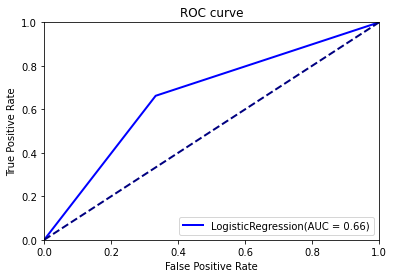

In [189]:
plot_AUC(y_test,y_test_pred_lr,'LogisticRegression')

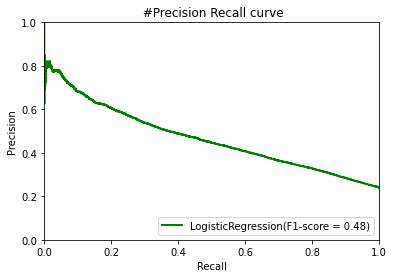

In [190]:
plot_PR_Curve(y_test,probs_lr,'LogisticRegression',f1_score(y_test,y_test_pred_lr))

In [191]:
log_reg_stats=build_logistic_model(X_train_sm,y_train_sm)

Optimization terminated successfully.
         Current function value: 0.587505
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               329884
Model:                          Logit   Df Residuals:                   329852
Method:                           MLE   Df Model:                           31
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.1524
Time:                        10:59:55   Log-Likelihood:            -1.9381e+05
converged:                       True   LL-Null:                   -2.2866e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                              -0.1981      0.005

In [192]:
features_scores=corr_F_P_scores(X,y)
features_scores

,Correlation,Fscore,Pvalue
loan_amnt,-0.095343,2476.850,0.000
grade,-0.058680,932.893,0.000
emp_length,-0.028059,212.732,0.000
zip_code,0.025419,174.563,0.000
delinq_2yrs,-0.046496,584.975,0.000
inq_last_6mths,0.087834,2099.175,0.000
pub_rec,-0.049138,653.488,0.000
total_rec_late_fee,-0.003907,4.122,0.042
recoveries,-0.063569,1095.480,0.000
collection_recovery_fee,-0.044280,530.436,0.000


#### Random Forest Classifier

In [199]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [200]:
X_train_sm1, y_train_sm1 = smote.fit_resample(X_train1, y_train1)
print('Before Resampling dataset shape %s' % Counter(y_train1))
print('Resampled dataset shape %s' % Counter(y_train_sm1))

Before Resampling dataset shape Counter({0: 164942, 1: 51058})
Resampled dataset shape Counter({0: 164942, 1: 164942})


In [201]:
class_weights={0:1,1:100}
#give more importance to 1(100 times more) as compared to 0.
rf_classifier=RandomForestClassifier(random_state=21,class_weight=class_weights)
rf_classifier.fit(X_train_sm1,y_train_sm1)
y_train_pred_rf=rf_classifier.predict(X_train_sm1)
y_test_pred_rf=rf_classifier.predict(X_test1)
y_test_pred_prob_rf=rf_classifier.predict_proba(X_test1)

In [202]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_rf),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_rf),2)*100))
print(classification_report(y_test1,y_test_pred_rf))

Training Accuracy=100.0%
Testing Accuracy=79.0%
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     41236
           1       0.60      0.33      0.43     12764

    accuracy                           0.79     54000
   macro avg       0.71      0.63      0.65     54000
weighted avg       0.77      0.79      0.77     54000



In [203]:
#model
rf_model = RandomForestClassifier() 
#Implement RandomSearchCV
model_params = { 
            "n_estimators" :  [1000,1500],
             "criterion": ["entropy"],
            }

random_search_rf = RandomizedSearchCV(rf_model, param_distributions = model_params, 
                                       scoring = 'recall',               
                                       return_train_score = True,
                                       random_state = 42,
                                       cv = 5,
                                       verbose = 5,n_jobs=-1) 
random_search_rf.fit(X_train_sm1,y_train_sm1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy'],
                                        'n_estimators': [1000, 1500]},
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=5)

In [200]:
print(random_search_rf.best_estimator_)
print(random_search_rf.best_params_)

RandomForestClassifier(criterion='entropy', n_estimators=1000)
{'n_estimators': 1000, 'criterion': 'entropy'}


In [204]:
rf_classifier_hyp=random_search_rf.best_estimator_
rf_classifier_hyp.fit(X_train_sm1,y_train_sm1)

RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [ ]:
#After Random search the best estimator found is
#RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [205]:
y_train_pred_rf_hyp=rf_classifier_hyp.predict(X_train_sm1)
y_test_pred_rf_hyp=rf_classifier_hyp.predict(X_test1)
y_test_pred_prob_rf_rcv=rf_classifier_hyp.predict_proba(X_test1)

In [221]:
#recover the best model
rf_best_model = random_search_rf.best_estimator_
rf_best_model_df=pd.DataFrame(random_search_rf.cv_results_)
rf_best_model_df.to_csv("rf_randomsearch_09nov.csv")

In [207]:
train_acc_RandomForest=accuracy_score(y_train_sm1,y_train_pred_rf_hyp)
test_acc_RandomForest=accuracy_score(y_test1,y_test_pred_rf_hyp)
prec_RandomForest=precision_score(y_test1,y_test_pred_rf_hyp)
recall_RandomForest=recall_score(y_test1,y_test_pred_rf_hyp)
F1score_RandomForest=f1_score(y_test1,y_test_pred_rf_hyp)

In [208]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_rf_hyp),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_rf_hyp),2)*100))
print(classification_report(y_test1,y_test_pred_rf_hyp))

Training Accuracy=100.0%
Testing Accuracy=79.0%
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     41236
           1       0.61      0.35      0.44     12764

    accuracy                           0.79     54000
   macro avg       0.71      0.64      0.66     54000
weighted avg       0.77      0.79      0.77     54000



#### Adjust the threshold

In [209]:
y_test_pred_prob_rf_hyp=rf_classifier_hyp.predict_proba(X_test1)
probs_rf_hyp = y_test_pred_prob_rf_hyp[:,1]

In [210]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
f1scores = [f1_score(y_test1, to_labels(probs_rf_hyp, t)) for t in thresholds]
# get best threshold
ix = np.argmax(f1scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], f1scores[ix]))

Threshold=0.318, F-Score=0.50660


In [211]:
y_test_pred_rf_th = np.where(probs_rf_hyp>= 0.318, 1, 0)

In [212]:
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_rf_th),2)*100))
print(classification_report(y_test1,y_test_pred_rf_th))

Testing Accuracy=73.0%
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     41236
           1       0.45      0.58      0.51     12764

    accuracy                           0.73     54000
   macro avg       0.65      0.68      0.66     54000
weighted avg       0.76      0.73      0.74     54000



In [213]:
y_train_pred_rf_th=rf_classifier_hyp.predict(X_train_sm1)

In [214]:
train_acc_RandomForest1=accuracy_score(y_train_sm1,y_train_pred_rf_th)
test_acc_RandomForest1=accuracy_score(y_test1,y_test_pred_rf_th)
prec_RandomForest1=precision_score(y_test1,y_test_pred_rf_th)
recall_RandomForest1=recall_score(y_test1,y_test_pred_rf_th)
F1score_RandomForest1=f1_score(y_test1,y_test_pred_rf_th)

### Adaboost classifier

In [215]:
abc = AdaBoostClassifier(n_estimators=2000,learning_rate=0.01, random_state=42)
# Train Adaboost Classifer
abc_model = abc.fit(X_train_sm1,y_train_sm1)

In [216]:
y_train_pred_abc=abc_model.predict(X_train_sm1)
y_test_pred_abc=abc_model.predict(X_test1)

In [217]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_abc),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_abc),2)*100))

Training Accuracy=80.0%
Testing Accuracy=73.0%


In [218]:
print(classification_report(y_test1,y_test_pred_abc))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82     41236
           1       0.45      0.51      0.48     12764

    accuracy                           0.73     54000
   macro avg       0.64      0.66      0.65     54000
weighted avg       0.75      0.73      0.74     54000



In [219]:
train_acc_adaboost=accuracy_score(y_train_sm1,y_train_pred_abc)
test_acc_adaboost=accuracy_score(y_test1,y_test_pred_abc)
prec_adaboost=precision_score(y_test1,y_test_pred_abc)
recall_adaboost=recall_score(y_test1,y_test_pred_abc)
F1score_adaboost=f1_score(y_test1,y_test_pred_abc)

In [220]:
parameters_abc = {
    'n_estimators': [1000,1500],
    'learning_rate': [0.01,0.1],
}
abc_grid = GridSearchCV(abc, parameters_abc, cv=5, verbose=5, n_jobs=-1,scoring='recall')
abc_grid.fit(X_train_sm1, y_train_sm1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(learning_rate=0.01, n_estimators=2000,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [1000, 1500]},
             scoring='recall', verbose=5)

In [ ]:
#After grid search the best estimator found is
#AdaBoostClassifier(learning_rate=0.01, n_estimators=1000, random_state=42)

In [231]:
abc_grid.best_estimator_

AdaBoostClassifier(learning_rate=0.01, n_estimators=1000, random_state=42)

In [222]:
#recover the best model
abc_best_model = abc_grid.best_estimator_
abc_best_model_df=pd.DataFrame(abc_grid.cv_results_)
abc_best_model_df.to_csv("abc_gridseach_8nov.csv")

In [223]:
abc_best_model.fit(X_train_sm1,y_train_sm1)
y_train_pred_abc_grid=abc_best_model.predict(X_train_sm1)
y_test_pred_abc_grid=abc_best_model.predict(X_test1)

In [224]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_abc_grid),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_abc_grid),2)*100))
print(classification_report(y_test1,y_test_pred_abc_grid))

Training Accuracy=78.0%
Testing Accuracy=72.0%
              precision    recall  f1-score   support

           0       0.85      0.77      0.81     41236
           1       0.42      0.55      0.48     12764

    accuracy                           0.72     54000
   macro avg       0.64      0.66      0.64     54000
weighted avg       0.75      0.72      0.73     54000



In [225]:
train_acc_adaboost1=accuracy_score(y_train_sm1,y_train_pred_abc_grid)
test_acc_adaboost1=accuracy_score(y_test1,y_test_pred_abc_grid)
prec_adaboost1=precision_score(y_test1,y_test_pred_abc_grid)
recall_adaboost1=recall_score(y_test1,y_test_pred_abc_grid)
F1score_adaboost1=f1_score(y_test1,y_test_pred_abc_grid)

In [226]:
# predict probabilities
y_test_pred_prob_abc = abc_best_model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
probs_abc_hyp = y_test_pred_prob_abc[:, 1]

In [227]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test1, to_labels(probs_abc_hyp, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.499, F-Score=0.48106


In [228]:
y_test1_pred_abc_grid = np.where(probs_abc_hyp>= 0.499, 1, 0)

In [229]:
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test1_pred_abc_grid),2)*100))
print(classification_report(y_test1,y_test1_pred_abc_grid))

Testing Accuracy=71.0%
              precision    recall  f1-score   support

           0       0.85      0.75      0.80     41236
           1       0.42      0.57      0.48     12764

    accuracy                           0.71     54000
   macro avg       0.63      0.66      0.64     54000
weighted avg       0.75      0.71      0.72     54000



In [230]:
train_acc_adaboost2=accuracy_score(y_train_sm1,y_train_pred_abc_grid)
test_acc_adaboost2=accuracy_score(y_test1,y_test1_pred_abc_grid)
prec_adaboost2=precision_score(y_test1,y_test1_pred_abc_grid)
recall_adaboost2=recall_score(y_test1,y_test1_pred_abc_grid)
F1score_adaboost2=f1_score(y_test1,y_test1_pred_abc_grid)

#### Gradboost classifier

In [232]:
grd_boost = GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000)
grd_boost.fit(X_train_sm1,y_train_sm1)
y_train_pred_grd=grd_boost.predict(X_train_sm1)
y_test_pred_grd=grd_boost.predict(X_test1)

In [233]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_grd),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_grd),2)*100))
print(classification_report(y_test1,y_test_pred_abc))

Training Accuracy=86.0%
Testing Accuracy=79.0%
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     41236
           1       0.45      0.51      0.48     12764

    accuracy                           0.73     54000
   macro avg       0.64      0.66      0.65     54000
weighted avg       0.75      0.73      0.74     54000



In [234]:
train_acc_Gradientboost=accuracy_score(y_train_sm1,y_train_pred_grd)
test_acc_Gradientboost=accuracy_score(y_test1,y_test_pred_grd)
prec_Gradientboost=precision_score(y_test1,y_test_pred_grd)
recall_Gradientboost=recall_score(y_test1,y_test_pred_grd)
F1score_Gradientboost=f1_score(y_test1,y_test_pred_grd)

In [235]:
parameters_grd = {
    "n_estimators":[1000,1500,2000],
    "learning_rate":[0.01,0.1,0.2]
}

grd_clf = GridSearchCV(grd_boost, parameters_grd, cv=5, verbose=5, n_jobs=-1,scoring='recall')
grd_clf.fit(X_train_sm1, y_train_sm1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  n_estimators=2000),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [1000, 1500, 2000]},
             scoring='recall', verbose=5)

In [ ]:
------

In [ ]:
#After grid search the best estimator found is
#GradientBoostingClassifier(learning_rate=0.2, n_estimators=2000)

In [253]:
#recover the best model
grd_best_model = grd_clf.best_estimator_
grd_best_model_df=pd.DataFrame(grd_clf.cv_results_)
grd_best_model_df.to_csv("grd_gridseach_08.csv")

In [254]:
grd_best_model.fit(X_train_sm1,y_train_sm1)
y_train_pred_grd_gcv=grd_best_model.predict(X_train_sm1)
y_test_pred_grd_gcv=grd_best_model.predict(X_test1)

In [255]:
print("Training Accuracy={}%".format(np.round(accuracy_score(y_train_sm1,y_train_pred_grd_gcv),2)*100))
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test_pred_grd_gcv),2)*100))
print(classification_report(y_test1,y_test_pred_grd_gcv))

Training Accuracy=89.0%
Testing Accuracy=82.0%
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     41236
           1       0.76      0.36      0.49     12764

    accuracy                           0.82     54000
   macro avg       0.80      0.66      0.69     54000
weighted avg       0.81      0.82      0.80     54000



In [266]:
train_acc_Gradientboost1=accuracy_score(y_train_sm1,y_train_pred_grd_gcv)
test_acc_Gradientboost1=accuracy_score(y_test1,y_test_pred_grd_gcv)
prec_Gradientboost1=precision_score(y_test1,y_test_pred_grd_gcv)
recall_Gradientboost1=recall_score(y_test1,y_test_pred_grd_gcv)
F1score_Gradientboost1=f1_score(y_test1,y_test_pred_grd_gcv)

In [260]:
# predict probabilities
y_test_pred_prob_grd = grd_best_model.predict_proba(X_test1)
# keep probabilities for the positive outcome only
probs_grd_hyp = y_test_pred_prob_grd[:, 1]

In [261]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores_grd = [f1_score(y_test1, to_labels(probs_grd_hyp, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores_grd)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores_grd[ix]))

Threshold=0.304, F-Score=0.56099


In [264]:
y_test1_pred_grd = np.where(probs_grd_hyp>= 0.34, 1, 0)

In [265]:
print("Testing Accuracy={}%".format(np.round(accuracy_score(y_test1,y_test1_pred_grd),2)*100))
print(classification_report(y_test1,y_test1_pred_grd))

Testing Accuracy=80.0%
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     41236
           1       0.59      0.53      0.55     12764

    accuracy                           0.80     54000
   macro avg       0.72      0.71      0.71     54000
weighted avg       0.79      0.80      0.80     54000



In [267]:
train_acc_Gradientboost2=accuracy_score(y_train_sm1,y_train_pred_grd)
test_acc_Gradientboost2=accuracy_score(y_test1,y_test1_pred_grd)
prec_Gradientboost2=precision_score(y_test1,y_test1_pred_grd)
recall_Gradientboost2=recall_score(y_test1,y_test1_pred_grd)
F1score_Gradientboost2=f1_score(y_test1,y_test1_pred_grd)

In [281]:
model_performance_summary={
    
'model':['LogisticRegression','RandomForest','Adaboost',
         'Gradientboost'],
    
'Training_Accuracy': [train_acc_LogReg, 
                      train_acc_RandomForest1,
                      train_acc_adaboost2,
                      train_acc_Gradientboost2],   
'Testing_Accuracy': [test_acc_LogReg, 
                     test_acc_RandomForest1,
                     test_acc_adaboost2,
                     test_acc_Gradientboost2],
'Precission':[prec_LogReg, 
              prec_RandomForest1,
              prec_adaboost2,
              prec_Gradientboost],
'Recall':[recall_LogReg, 
          recall_RandomForest1,
          recall_adaboost2,
          recall_Gradientboost2],
'F1score':[F1score_LogReg, 
           F1score_RandomForest1,
           F1score_adaboost2,
           F1score_Gradientboost2]
}

In [282]:
summary_df=pd.DataFrame.from_dict(model_performance_summary)

In [283]:
summary_df

,model,Training_Accuracy,Testing_Accuracy,Precission,Recall,F1score
0,LogisticRegression,0.693235,0.668722,0.382621,0.654419,0.482902
1,RandomForest,1.000000,0.749704,0.474809,0.555233,0.511882
2,Adaboost,0.783394,0.710667,0.417646,0.568160,0.481413
3,Gradientboost,0.858738,0.800185,0.606457,0.527107,0.554978


In [ ]:
#After checking the model performance with different classifiers. 
#Gradient boost Algorithm is selected finally as it is giving good accuracy and f1score

In [268]:
final_columns_unseen=X.columns

In [270]:
X_unseen=train_df_final[final_columns_unseen]
y_unseen=train_df_final['loan_status']

In [271]:
y_pred_grd_unseen=grd_best_model.predict(X_unseen)

In [272]:
accuracy_score(y_unseen,y_pred_grd_unseen)

0.8292555555555555

In [273]:
print(classification_report(y_unseen,y_pred_grd_unseen))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90    206178
           1       0.80      0.37      0.51     63822

    accuracy                           0.83    270000
   macro avg       0.82      0.67      0.70    270000
weighted avg       0.82      0.83      0.80    270000



In [274]:
# predict probabilities
yhat_unseen = grd_best_model.predict_proba(X_unseen)
# keep probabilities for the positive outcome only
probs_unseen = yhat_unseen[:, 1]

In [315]:
y_pred_unseen = np.where(probs_unseen>= 0.304, 1, 0)

In [316]:
print(classification_report(y_unseen,y_pred_unseen))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87    206178
           1       0.57      0.61      0.59     63822

    accuracy                           0.80    270000
   macro avg       0.72      0.73      0.73    270000
weighted avg       0.80      0.80      0.80    270000



In [317]:
acc_unseen=accuracy_score(y_unseen,y_pred_unseen)
prec_unseen=precision_score(y_unseen,y_pred_unseen)
recall_unseen=recall_score(y_unseen,y_pred_unseen)
F1score_unseen=f1_score(y_unseen,y_pred_unseen)

In [329]:
valid_summary={
               'Model':'Gradientboost',
               'Accuracy':[np.round(acc_unseen,2)],
               'Precision':[np.round(prec_unseen,2)],
               'Recall':[np.round(recall_unseen,2)],
               'F1_Score':[np.round(F1score_unseen,2)]
              }

In [330]:
valid_summary_df=pd.DataFrame.from_dict(valid_summary)
valid_summary_df

,Model,Accuracy,Precision,Recall,F1_Score
0,Gradientboost,0.8,0.57,0.61,0.59


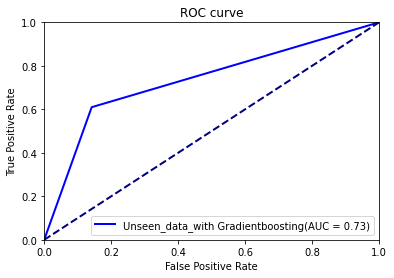

In [279]:
plot_AUC(y_unseen,y_pred_unseen,'Gradientboost-Vaidationdata')

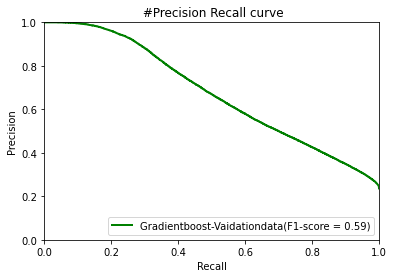

In [294]:
plot_PR_Curve(y_unseen,probs_unseen,'Gradientboost-Vaidationdata',f1_score(y_unseen,y_pred_unseen))